# i. Business Understanding

## i.i Insurance All Company

* Insurance All is a company that provides health insurance to its customers and the product team is analyzing the possibility of offering policyholders a new product: auto insurance.

* like health insurance, customers of this new auto insurance plan need to pay an amount annually to Insurance All to obtain an amount insured by the company, intended for the costs of an eventual accident or damage to the vehicle.

* Insurance All conducted a survey of about 380,000 customers about their interest in joining a new auto insurance product last year. All customers expressed interest or not in purchasing auto insurance and these responses were saved in a database along with other customer attributes.

* The product team selected 127 thousand new customers who did not respond to the survey to participate in a campaign, in which they will receive the offer of the new auto insurance product. The offer will be made by the sales team through telephone calls.

* However, the sales team has the capacity to make 20 thousand calls within the campaign period.

## i.ii The Challenge

* You were hired as a Data Science consultant to build a model that predicts whether or not the customer would be interested in auto insurance.

* With the solution, the sales team hopes to be able to prioritize the people who are most interested in the new product and, thus, optimize the campaign by making only contacts with customers most likely to make the purchase.

### i.ii.i Business Questions

1. What are the main insights on the most relevant attributes of relevant customers in purchasing auto insurance.

1. What percentage of customers are interested in purchasing auto insurance? Will the sales team be able to reach you by making 20,000 calls?

1. If the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?

1. How many calls does the sales team need to make to contact 80% of customers interested in purchasing auto insurance?

# 0.0 Imports and Helper Functions

## 0.1 Imports

In [1]:
import os
import joblib
import warnings
import inflection

import numpy             as np
import pandas            as pd
import seaborn           as sns
import psycopg2          as pg
import scikitplot        as skplt
import category_encoders as ce

import sklearn.metrics   as mtr
import matplotlib.pyplot as plt

from scipy       import stats
from boruta      import BorutaPy

from IPython.display      import Image
from IPython.core.display import HTML 

from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.dummy        import DummyClassifier
from sklearn.ensemble     import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing    import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection  import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectFromModel

## 0.2 Helper Functions

In [3]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    sns.set(font_scale=1.6)
    
    plt.style.use('seaborn-darkgrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16
    
    display( HTML('<style>.container {width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [5]:
def calcCramerV(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [6]:
def getLifeStage(age):
    if age <= 3:
        life_stage = "Infancy"
    
    elif age > 3 and age <= 6:
        life_stage = "Early Childhood"
        
    elif age > 6 and age <= 8:
        life_stage = "Middle Childhood"
        
    elif age >= 9 and age <= 11:
        lige_stage = "Late Childhood"
        
    elif age >= 12 and age <= 20:
        life_stage = "Adolescence"
        
    elif age > 20 and age <= 35:
        life_stage = "Early Adulthood"
        
    elif age > 35 and age <= 50:
        life_stage = "Midlife"
        
    elif age > 50 and age <= 80:
        life_stage = "Mature Adulthood"
        
    else:
        life_stage = "Late Adulthood"
        
    return life_stage

In [7]:
def normal_tests(data):
    bx = stats.boxcox(data)[0]
    sq = np.sqrt(data)
    cb = np.cbrt(data)
    log = np.log(data)
    
    return pd.DataFrame({
        'Shapiro': [stats.shapiro(data)[0], stats.shapiro(bx)[0], stats.shapiro(sq)[0], stats.shapiro(cb)[0], stats.shapiro(log)[0]],
        'Skew': [stats.skew(data), stats.skew(bx), stats.skew(sq), stats.skew(cb), stats.skew(log)],
        'Kurtosis': [stats.kurtosis(data), stats.kurtosis(bx), stats.kurtosis(sq), stats.kurtosis(cb), stats.kurtosis(log)]
    }, index=['default', 'boxcox', 'sqrt', 'cuberoot', 'log'])

In [8]:
def top_k_precision(y_true, y_score, k=10, return_df=False):
    df = pd.DataFrame({'true': y_true, 'score': y_score[:, 1]})
    
    df.sort_values('score', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    df['ranking'] = df.index + 1
    df['precision_top_k'] = df['true'].cumsum()/df['ranking']
    
    if return_df:
        return df.loc[k, 'precision_top_k'], df
    
    else:
        return df.loc[k, 'precision_top_k']

In [9]:
def top_k_recall(y_true, y_score, k=10, return_df=False):
    df = pd.DataFrame({'true': y_true, 'score': y_score[:, 1]})
    
    df.sort_values('score', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    df['ranking'] = df.index + 1
    df['recall_top_k'] = df['true'].cumsum()/df['true'].sum()

    if return_df:
        return df.loc[k, 'precision_top_k'], df
    
    else:
        return df.loc[k, 'precision_top_k']

In [10]:
def top_k_f1score(y_true, y_score, k=10):

    precision = top_k_precision(y_true, y_score, k)
    recall = top_k_recall(y_true, y_score, k)

    f1 = 2 * (precision * recall) / (precision + recall)

    return f1

In [11]:
def ml_cv_results(model_name, model, x, y, verbose=1):
    
    '''initial'''
    precisions = []
    recalls = []
    f1s = []
    
    ## defining
    ohe_columns = ['previously_insured', 'vehicle_damage']
    ohe = ce.OneHotEncoder(cols=ohe_columns, use_cat_names=True)
    
    te_columns = ['policy_sales_channel']
    te = ce.TargetEncoder(cols=te_columns, return_df=False)
    
    mm = MinMaxScaler()
    
    ss = StandardScaler()
    
    cs = ['previously_insured_yes', 'previously_insured_no', 'vehicle_damage_no',
          'vehicle_damage_yes', 'policy_sales_channel_te', 'age_bx_ss', 'age_mm']
    
    ## defining as array
    x_ = x.to_numpy()
    y_ = y.to_numpy()
    
    count = 0
    
    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    for index_train, index_test in skf.split(x_, y_):
        
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))
    
        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
        
        ## data preparation
        x_train = ohe.fit_transform(x_train)
        x_test = ohe.transform(x_test)
        
        x_train['policy_sales_channel_te'] = te.fit_transform(x_train['policy_sales_channel'], y_train)
        x_test['policy_sales_channel_te'] = te.transform(x_test['policy_sales_channel'], y_test)
        
        x_train['age_bx'] = stats.boxcox(x_train['age'])[0]
        x_test['age_bx'] = stats.boxcox(x_test['age'])[0]
        
        x_train.loc[:, 'age_bx_ss'] = ss.fit_transform(x_train[['age_bx']])
        x_test.loc[:, 'age_bx_ss'] = ss.transform(x_test[['age_bx']])
        
        x_train.loc[:, 'age_mm'] = mm.fit_transform(x_train[['age']])
        x_test.loc[:, 'age_mm'] = mm.transform(x_test[['age']])
    
        x_train = x_train[cs]
        x_test = x_test[cs]
    
        ## training the model
        model.fit(x_train, y_train)
        y_prob = model.predict_proba(x_test)

        ## saving the metrics
        k = int(0.5 * y_test.shape[0])
        
        precision = top_k_precision(y_test, y_prob, k=k)
        recall = top_k_recall(y_test, y_prob, k=k)
        f1 = 2*(precision*recall) / (precision+recall)
        
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        
    '''results'''
    precision_mean, precision_std = np.round(np.mean(precisions), 4), np.round(np.std(precisions), 4)
    recall_mean, recall_std = np.round(np.mean(recalls), 4), np.round(np.std(recalls), 4)
    f1_mean, f1_std = np.round(np.mean(f1s), 4), np.round(np.std(f1s), 4)
    
    ## saving the results in a dataframe
    return pd.DataFrame({"Precision_at_k": "{} +/- {}".format(precision_mean, precision_std),
                         "Recall_at_k": "{} +/- {}".format(recall_mean, recall_std),
                         "F1_at_k": "{} +/- {}".format(f1_mean, f1_std)},
                        index=[model_name])

In [12]:
def ml_top_k_scores(model_name, y_true, y_score, k=10):
    
    precision = top_k_precision(y_true, y_score, k)
    recall = top_k_recall(y_true, y_score, k)
    f1 = top_k_f1score(y_true, y_score, k)
    
    return pd.DataFrame({'Precision_at_k': np.round(precision, 4), 
                         'Recall_at_k': np.round(recall, 4),
                         'F1_at_k': np.round(f1, 4)},
                        index=[model_name])

# 1.0 Data Description

## 1.1 Loading Data

In [3]:
params_dict = {
    'host': os.getenv('HOST_CDS'),
    'port': os.getenv('PORT_CDS'),
    'database': os.getenv('DATABASE_CDS'),
    'username': os.getenv('USERNAME_CDS'),
    'pwd': os.getenv('PWD_CDS')
}

In [4]:
host = params_dict['host']
port = params_dict['port']
database = params_dict['database']
username = params_dict['username']
pwd = params_dict['pwd']

In [5]:
conn = pg.connect(user=username, password=pwd, host=host, port=port, database=database)

In [6]:
query_tables_users = '''
    select * 
    from pa004.users u, pa004.insurance i, pa004.vehicle v 
    where u.id = i.id and u.id = v.id;
'''

df1 = pd.read_sql(query_tables_users, conn)

conn.close()

In [7]:
df1.head()

,id,gender,age,region_code,policy_sales_channel,id,previously_insured,annual_premium,vintage,response,id,driving_license,vehicle_age,vehicle_damage
0,7,Male,23,11.0,152.0,7,0,23367.0,249,0,7,1,< 1 Year,Yes
1,13,Female,41,15.0,14.0,13,1,31409.0,221,0,13,1,1-2 Year,No
2,18,Female,25,35.0,152.0,18,1,46622.0,299,0,18,1,< 1 Year,No
3,31,Female,26,8.0,160.0,31,0,2630.0,136,0,31,1,< 1 Year,No
4,39,Male,45,8.0,124.0,39,0,42297.0,264,0,39,1,1-2 Year,Yes


In [18]:
df1.tail()

,id,gender,age,region_code,policy_sales_channel,id,previously_insured,annual_premium,vintage,response,id,driving_license,vehicle_age,vehicle_damage
381104,381070,Male,24,8.0,152.0,381070,1,38254.0,127,0,381070,1,< 1 Year,No
381105,381079,Female,58,28.0,26.0,381079,0,39740.0,170,0,381079,1,1-2 Year,Yes
381106,381082,Female,75,28.0,26.0,381082,1,51619.0,80,0,381082,1,1-2 Year,No
381107,381097,Female,49,10.0,26.0,381097,0,34541.0,44,0,381097,1,1-2 Year,Yes
381108,381100,Female,51,28.0,26.0,381100,0,44504.0,71,0,381100,1,1-2 Year,Yes


## 1.2 Columns

### 1.2.1 Column Descriptions

* **Id:** Unique ID for the customer.
* **Gender:** Gender of the customer.
* **Age:** Age of the customer.
* **Driving License:** 0, customer does not have DL; 1, customer already has DL.
* **Region Code:** Unique code for the region of the customer.
* **Previously Insured:** 1, customer already has vehicle insurance; 0, customer doesn't have vehicle insurance.
* **Vehicle Age:** Age of the vehicle.
* **Vehicle Damage:** 1, customer got his/her vehicle damaged in the past; 0, customer didn't get his/her vehicle damaged in the past.
* **Anual Premium:** The amount customer needs to pay as premium in the year.
* **Policy sales channel:** Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
* **Vintage:** Number of Days, customer has been associated with the company.
* **Response:** 1, customer is interested; 0, customer is not interested.

### 1.2.2 Column Rename

The columns doesn't need to be changed.

### 1.2.3 Columns to Drop

In [19]:
df1 = df1.drop(columns=['id', 'id', 'id'], axis=1)

## 1.3 Data Dimensions

In [20]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Cols: 11


## 1.4 Data Types and Structures

In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                381109 non-null  object 
 1   age                   381109 non-null  int64  
 2   region_code           381109 non-null  float64
 3   policy_sales_channel  381109 non-null  float64
 4   previously_insured    381109 non-null  int64  
 5   annual_premium        381109 non-null  float64
 6   vintage               381109 non-null  int64  
 7   response              381109 non-null  int64  
 8   driving_license       381109 non-null  int64  
 9   vehicle_age           381109 non-null  object 
 10  vehicle_damage        381109 non-null  object 
dtypes: float64(3), int64(5), object(3)
memory usage: 32.0+ MB


## 1.5 Check NA

In [22]:
df1.isna().mean()

gender                  0.0
age                     0.0
region_code             0.0
policy_sales_channel    0.0
previously_insured      0.0
annual_premium          0.0
vintage                 0.0
response                0.0
driving_license         0.0
vehicle_age             0.0
vehicle_damage          0.0
dtype: float64

## 1.6 Fill Out NA

There's no values to fill

## 1.7 Change Data Type

I'll change the values of 0 to 'no' and 1 to 'yes' to improve the data analysis.

In [23]:
df1['previously_insured'] = df1['previously_insured'].map({0: 'no', 1: 'yes'})
df1['response'] = df1['response'].map({0: 'no', 1: 'yes'})
df1['driving_license'] = df1['driving_license'].map({0: 'no', 1: 'yes'})
df1['vehicle_damage'] = df1['vehicle_damage'].map({'Yes': 'yes', 'No': 'no'})

In [24]:
df1.head()

,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
0,Male,23,11.0,152.0,no,23367.0,249,no,yes,< 1 Year,yes
1,Female,41,15.0,14.0,yes,31409.0,221,no,yes,1-2 Year,no
2,Female,25,35.0,152.0,yes,46622.0,299,no,yes,< 1 Year,no
3,Female,26,8.0,160.0,no,2630.0,136,no,yes,< 1 Year,no
4,Male,45,8.0,124.0,no,42297.0,264,no,yes,1-2 Year,yes


## 1.8 Descriptions Statistics

In [25]:
num_attributes = df1.select_dtypes(exclude='object')
cat_attributes = df1.select_dtypes(include='object')

### 1.8.1 Numerical Attributes

In [26]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()
describe['mode'] = num_attributes.mode().T

describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis,mode
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,65.0,0.399551,0.672539,-0.565655,24.0
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0,52.0,0.501345,-0.115266,-0.867857,28.0
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0,162.0,0.483816,-0.900008,-0.970810,152.0
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0,537535.0,0.563177,1.766087,34.004569,2630.0
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,289.0,0.542097,0.003030,-1.200688,256.0


* The age mean is 39 years and the maximum value is 85 years. The variation is higher than 0.40. The skew is right skewed and kurtosis isn't 0, therefore the distribution isn't normal.
* The region code is not a normal distribution because it has got negative skew and kurtosis. The min code is 0 and it may be a invalid code. The variation is higher because it's 0.50.
* It has a higher negative skew and kurtosis!
* The range is 537,535, so there's a great difference in some users to pay. 
* The maximum number of days to be with the company is 299 days and 10 days is the minimum. The skew is almost 0.0000, however the variation coeficient is greater than 0.50 and kurstosis is negative.

### 1.8.2 Categorical Attributes

In [27]:
cat_attributes.describe().T

,count,unique,top,freq
gender,381109,2,Male,206089
previously_insured,381109,2,no,206481
response,381109,2,no,334399
driving_license,381109,2,yes,380297
vehicle_age,381109,3,1-2 Year,200316
vehicle_damage,381109,2,yes,192413


* There's only two types of gender and the top is male.
* The most common 'no', in other words, the most people in this database don't have vehicle insurance.
* The top value for driving_license is 'yes'. However, there are some people which doesn't have driving license.
* The vehicle age most common is 1-2 years.
* There are more accident vehicles than those that do not have an accident history.

## 1.9 Saves

In [28]:
df1.to_csv('../data/interim/data_step01_cycle1.csv', index=False)

# 2.0 Feature Engineering

## 2.1 Loading

In [29]:
df2 = pd.read_csv('../data/interim/data_step01_cycle1.csv')

## 2.2 Mind Map

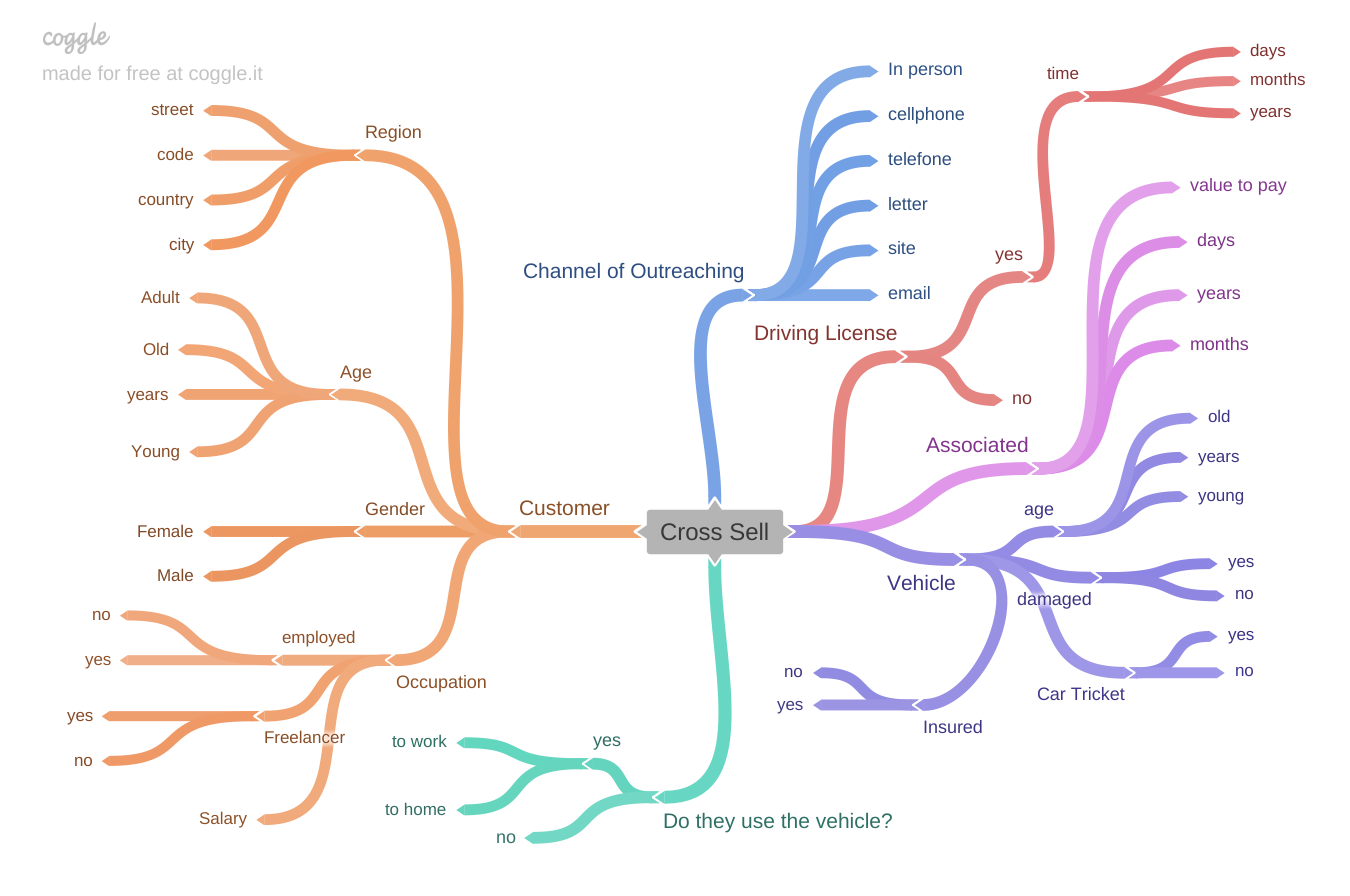

In [30]:
Image('../reports/figures/mind_map_cycle1.png')

## 2.3 Hypothesis Creation

### 2.3.1 Customer

* More than 60% of customers who want health insurance are women.
* Young people account for less than 30% of custumers who want health insurance.
* The older the customer, greater is the possibility of wanting health insurance.
* Employers account for more than 75% or more of customers who want health insurance.
* The high-salary ccustomers are more likely to get health insurance.

### 2.3.2 Vehicle

* Customers with car insurance are more lilkely to get health insurance.
* 60% or more of the customers with two-year-old vehicle are more likely to pay for health insurance.
* Less than 40% of customers who have damaged the vehicle don't want to get the health insurance.
* Customers who use the car to work are more likely to get health insurance.
* Customers with car ticket aren't more likely to get health insurance.
* Womens is 40% or less of the curstomers with car ticket.

### 2.3.3 Driving License

* Most customers are licensed to drive.
* Customers with two or more years licensed to drive are more likely to get health insurance.
* Customers with more one year or more licensed to drive have car ticket.
* 60% or more of the curstomers with one or more years of driving lincense have vehicle damages.
* The older is the vehicle, more likely the customers have a car ticket.

### 2.3.4 Associated

* Older customers are more likely to pay less for the annual health insurance.
* 70% or more of the customers with car insurance are more likely to get health insurance.
* Older customers and those which pay more for annual health insurance are more likely to get health insurance.
* 60% or more of the associated customers don't have car ticket.
* 70% or less of the associated customers are women.
* More than 60% of the associated customers are more likely to get health insurance.
* The more associated, more likely they may get the health insurance.

### 2.3.5 Channel of Outreaching

* 60% or more of the customers contacted by email are younger than 40 years.
* 75% or less of the telefone catacted customers are more likely to get health insurance.
* The most channel used to contact was the website advertisement for health insurance.
* 80% or more of the customers contacted by telefone are older than 60 years old.

## 2.4 Selected Hypothesis

1. More than 60% of customers who want health insurance are women.
1. Young people account for less than 30% of custumers who want health insurance.
2. The older the customer, greater is the possibility of wanting health insurance.
1. Customers with car insurance are more lilkely to get health insurance.
1. 60% or more of the customers with two-year-old vehicle are more likely to pay for health insurance.
1. Less than 40% of customers who have damaged the vehicle don't want to get the health insurance.
1. Older customers and those which pay more for annual health insurance are more likely to get health insurance.
1. The more associated, more likely they may get the health insurance.

## 2.5 Feature Engineering

In [31]:
## life stage
df2['life_stage'] = df2['age'].apply(getLifeStage)

## 2.6 Saves

In [32]:
df2.to_csv('../data/interim/data_step02_cycle1.csv', index=False)

# 3.0 Filtering Variables

## 3.1 Loading

In [33]:
df3 = pd.read_csv('../data/interim/data_step02_cycle1.csv')

## 3.2 Filtering Lines

There's no lines to be dropped from the dataset for data analysis.

## 3.3 Filtering Columns

There's no columns to drop.

## 3.4 Saves

In [34]:
df3.to_csv('../data/interim/data_step03_cycle1.csv', index=False)

# 4.0 Exploratory Data Analysis

## 4.1 Loading

In [35]:
df4 = pd.read_csv('../data/interim/data_step03_cycle1.csv')

## 4.2 Univariate Analysis

### 4.2.1 Response Variable

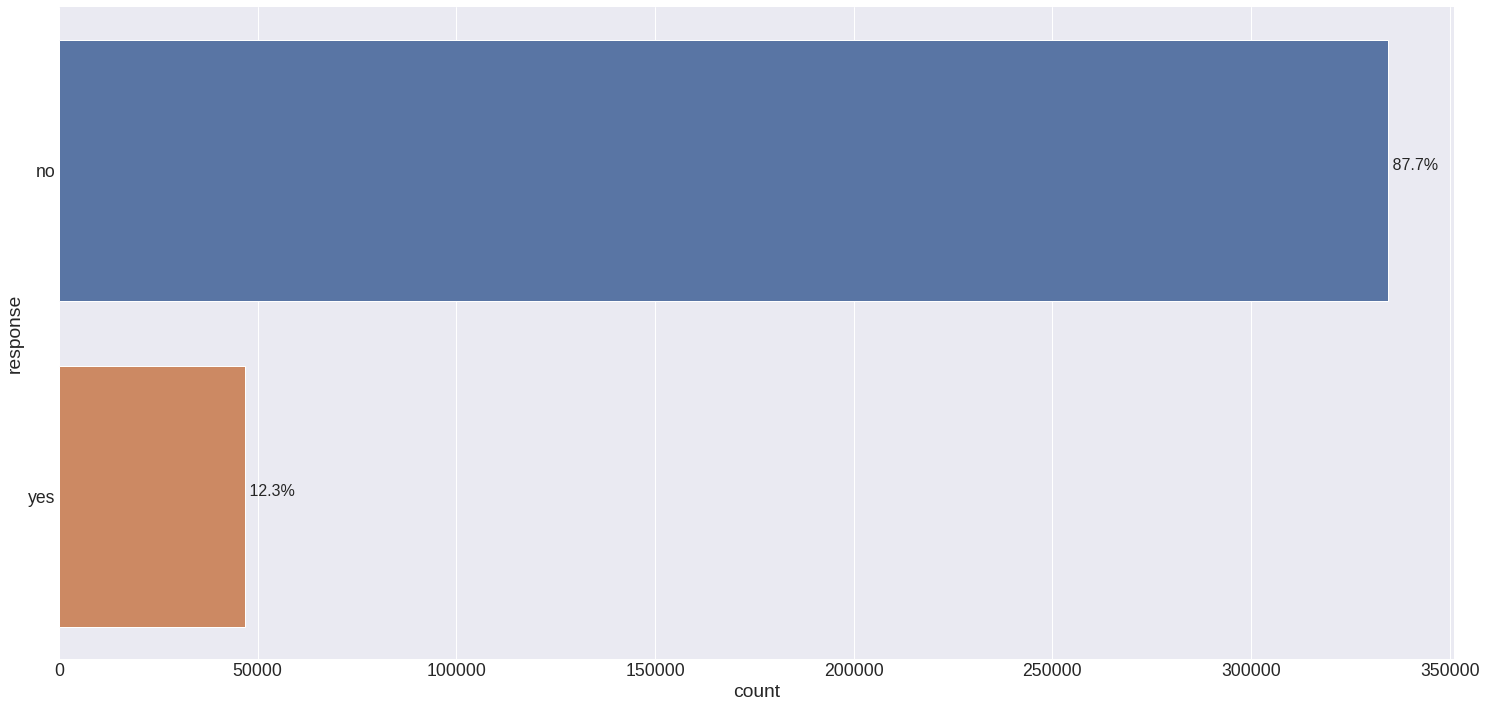

In [36]:
ax = sns.countplot(y='response', data=df4)

total = df4['response'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### 4.2.2 Numerical Variables

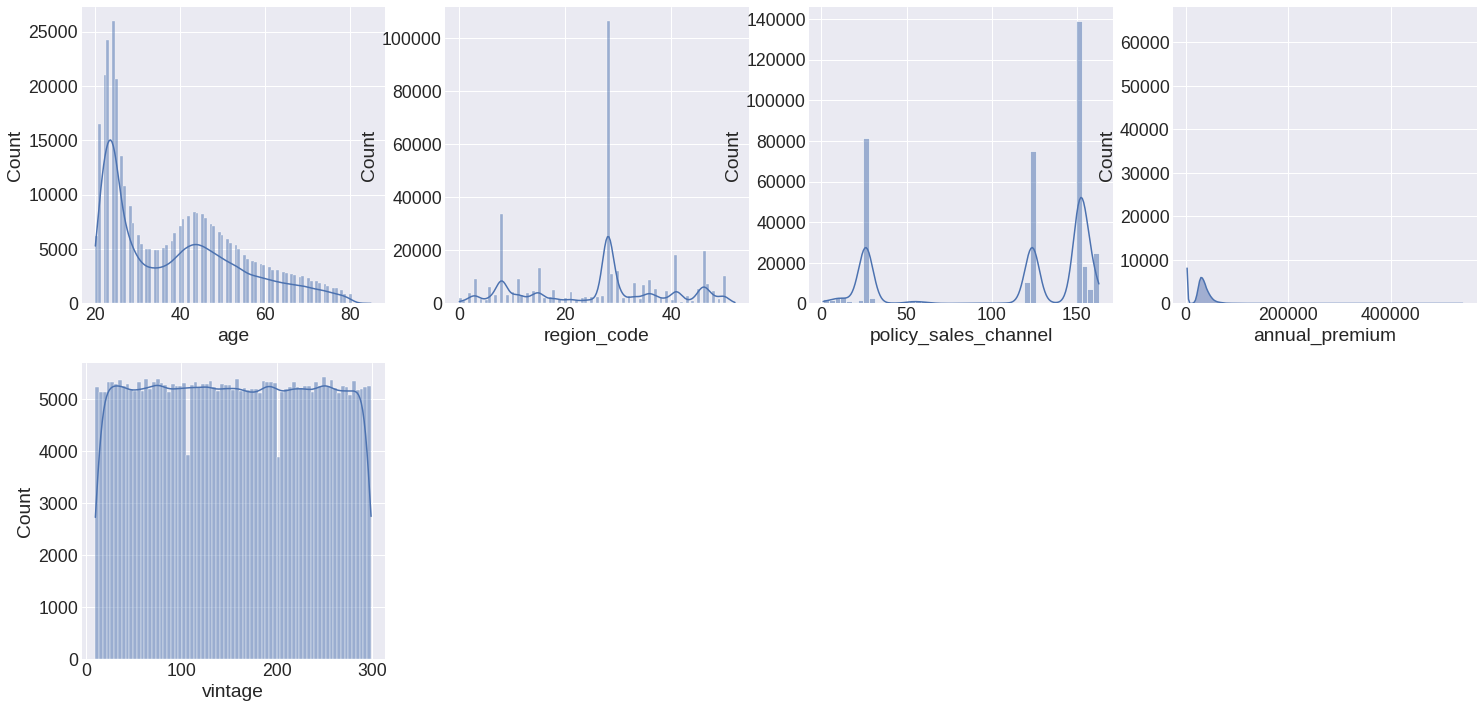

In [37]:
aux1 = df4.select_dtypes(exclude='object')
columns = aux1.columns.tolist()
j = 1

for column in columns:
    plt.subplot(2, 4, j)
    sns.histplot(aux1[column], kde=True);
    
    j += 1

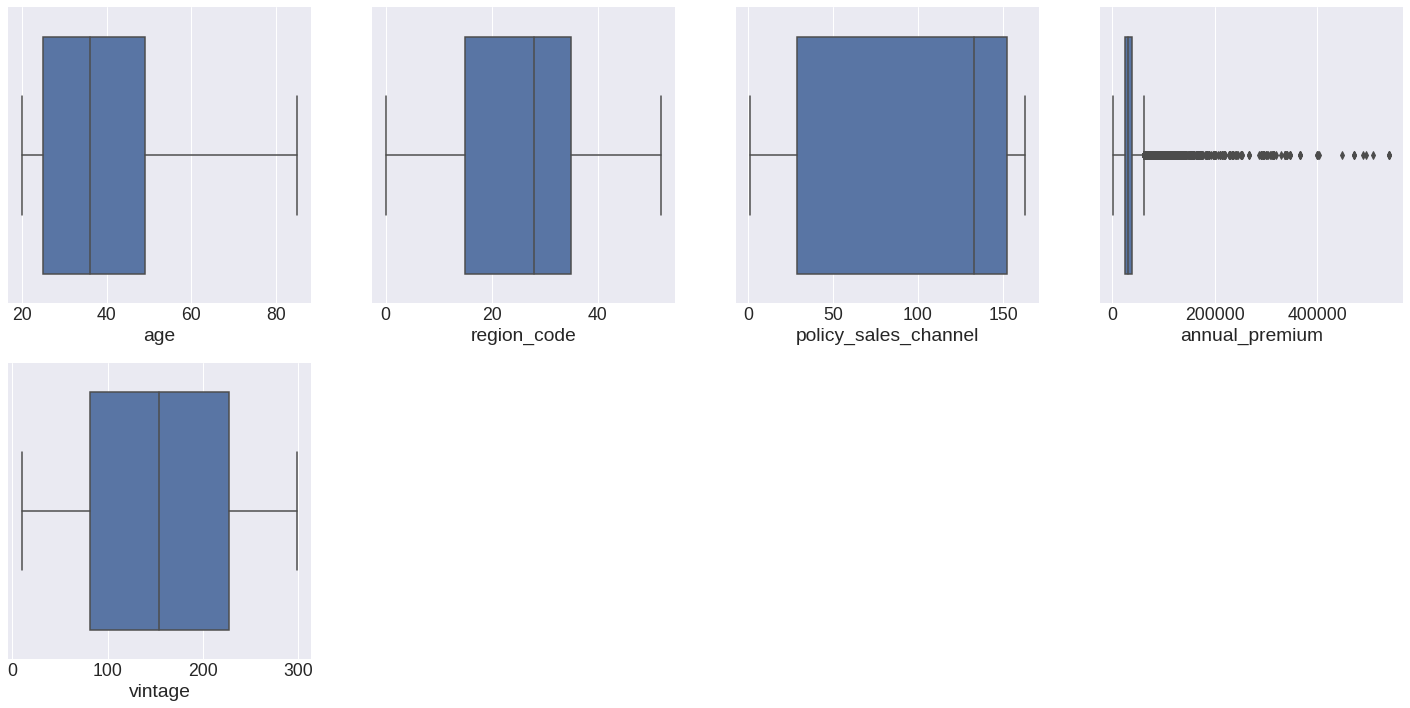

In [38]:
aux1 = df4.select_dtypes(exclude='object')
columns = aux1.columns.tolist()
j = 1

for column in columns:
    plt.subplot(2, 4, j)
    sns.boxplot(aux1[column]);
    
    j += 1

### 4.2.3 Categorical Variables

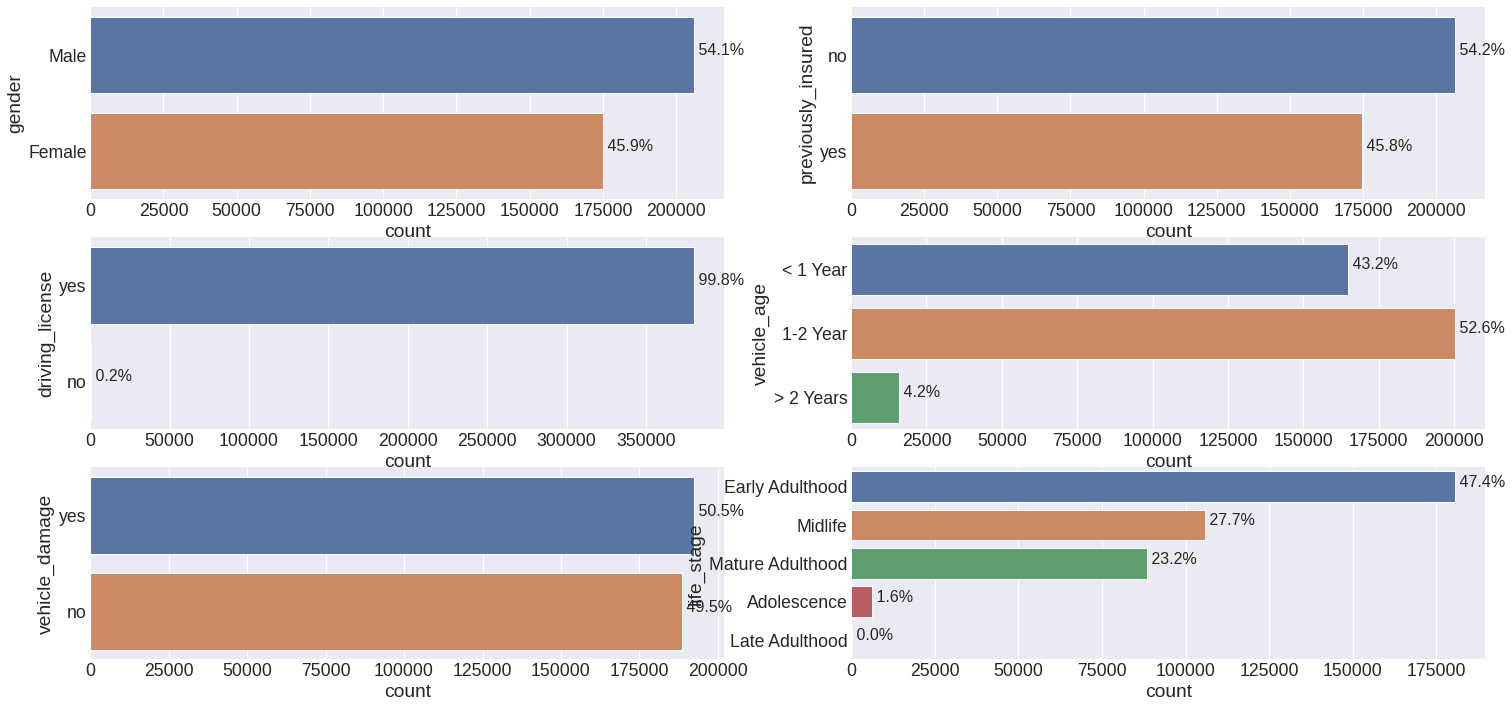

In [39]:
aux1 = df4.drop(columns=['response'], axis=1).select_dtypes(include='object')
columns = aux1.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=aux1)
    
    total = aux1[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1

## 4.3 Bivariate Analysis

### H1 More than 60% of customers who want health insurance are women.

**FALSE:** Women are about 38.9% of the customers who want health insurance. 

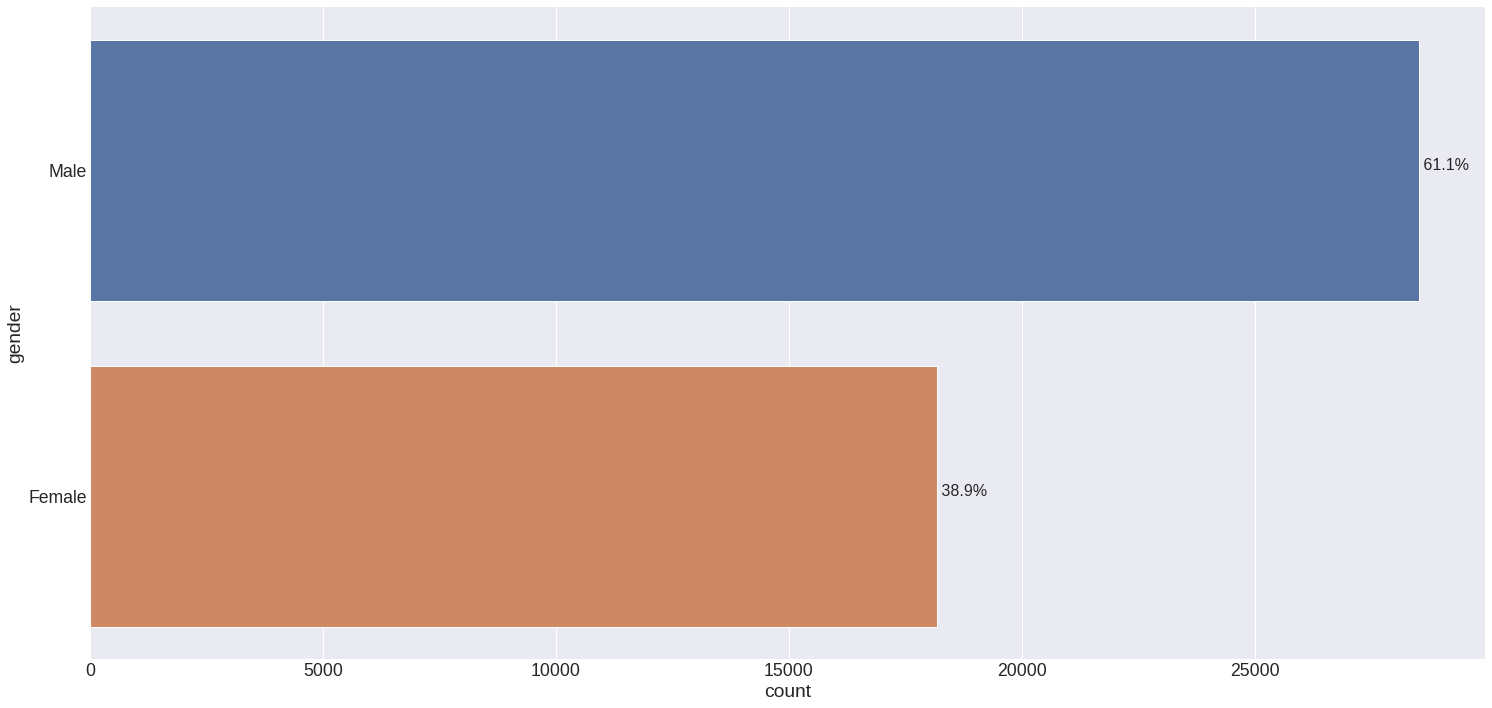

In [40]:
aux1 = df4[df4['response'] == 'yes']
ax = sns.countplot(y='gender', data=aux1)

total = aux1['gender'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H2 Young people account for less than 30% of custumers who want health insurance.

**TRUE:** Early Adulthood and adolescent are about 26.1% of the customers who want the health insurance. The mildlife customers are more likely to get health insurance, they are about 48.3%. 

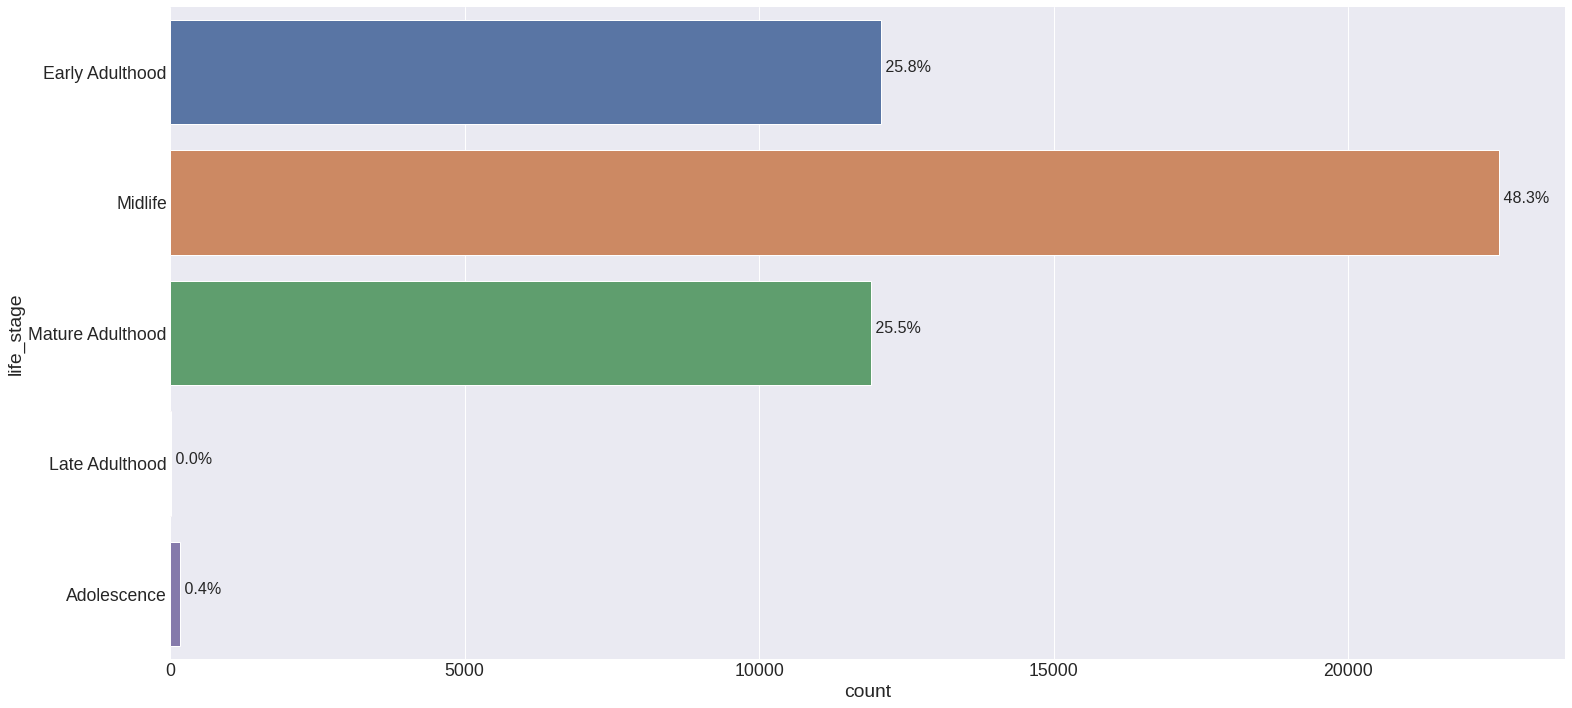

In [41]:
aux1 = df4[df4['response'] == 'yes']
ax = sns.countplot(y='life_stage', data=aux1)

total = aux1['life_stage'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H3 The older the customer, greater is the possibility of wanting health insurance.
**FALSE:** People who want health insurance are in 40 and 50 years old. However younger is the customer, they are more likely to do not want the health insurance.

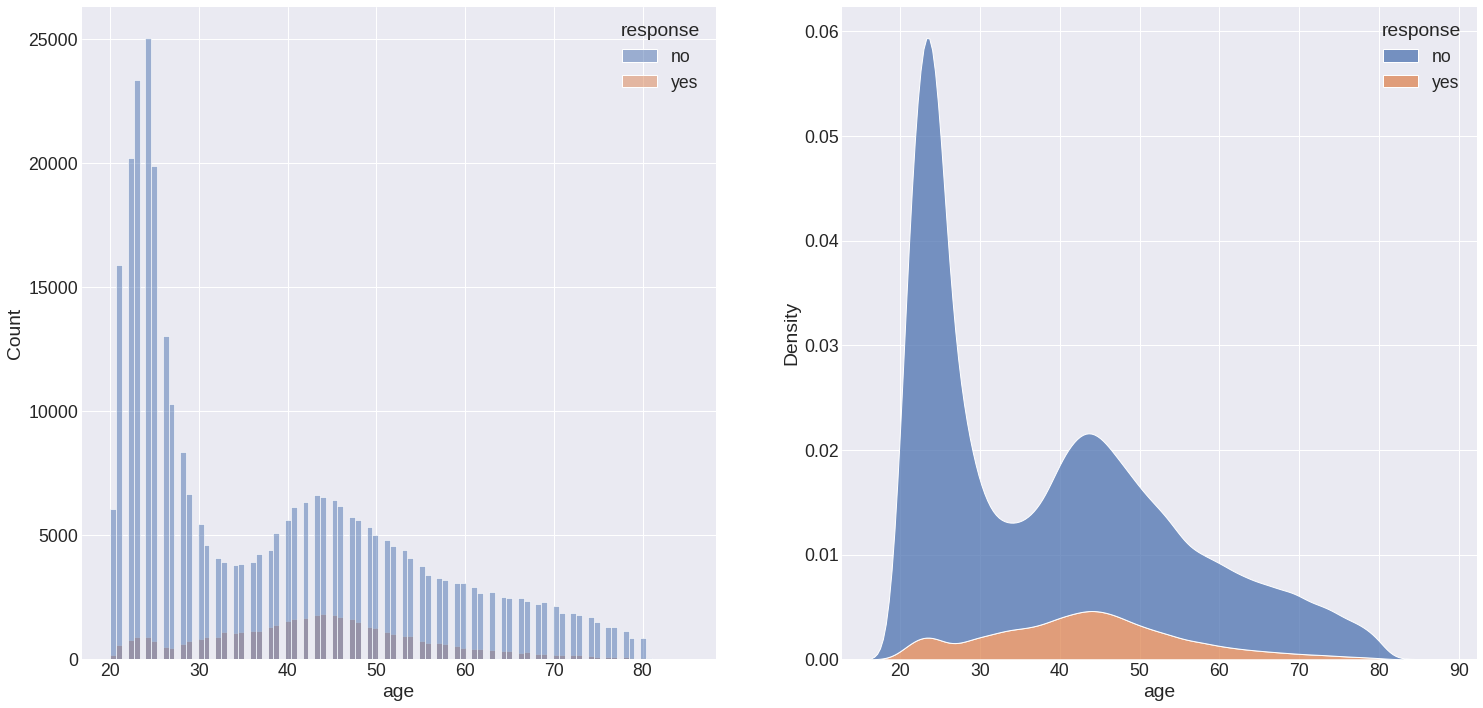

In [42]:
plt.subplot(1, 2, 1)
sns.histplot(x='age', data=df4, hue='response')

plt.subplot(1, 2, 2)
sns.kdeplot(x='age', data=df4, hue='response', multiple="stack");

### H4 Customers with car insurance are more lilkely to get health insurance.
**FALSE:** Customers without car insurance are more likely to get health insurance. In this database 99.7% of customers are previously insured.

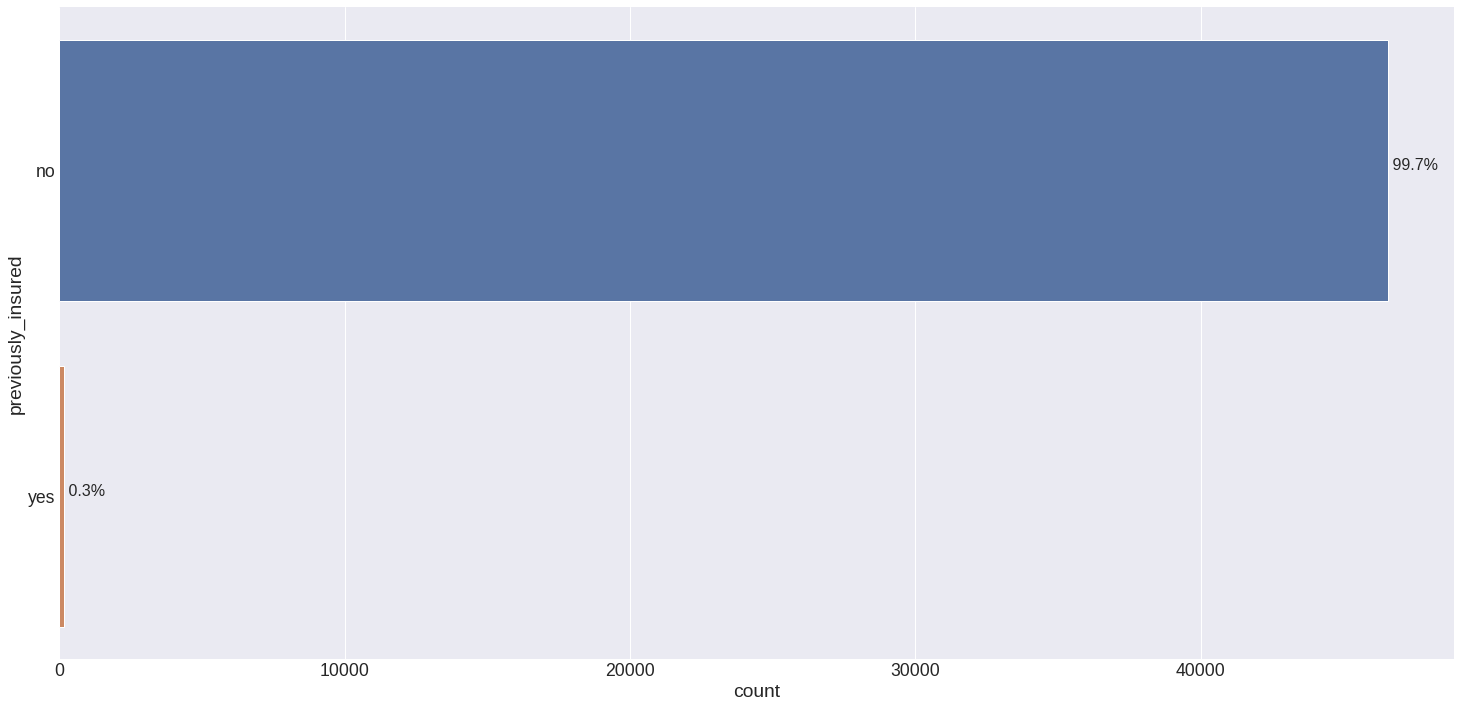

In [43]:
aux1 = df4[df4['response'] == 'yes']
ax = sns.countplot(y='previously_insured', data=aux1);

total = aux1['previously_insured'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H5 60% or more of the customers with two-year-old vehicle are more likely to pay for health insurance.
**FALSE:** Customers with vehicle between one and two years are about 74.5%. However for customers with 2 years or more are about 10.1%.

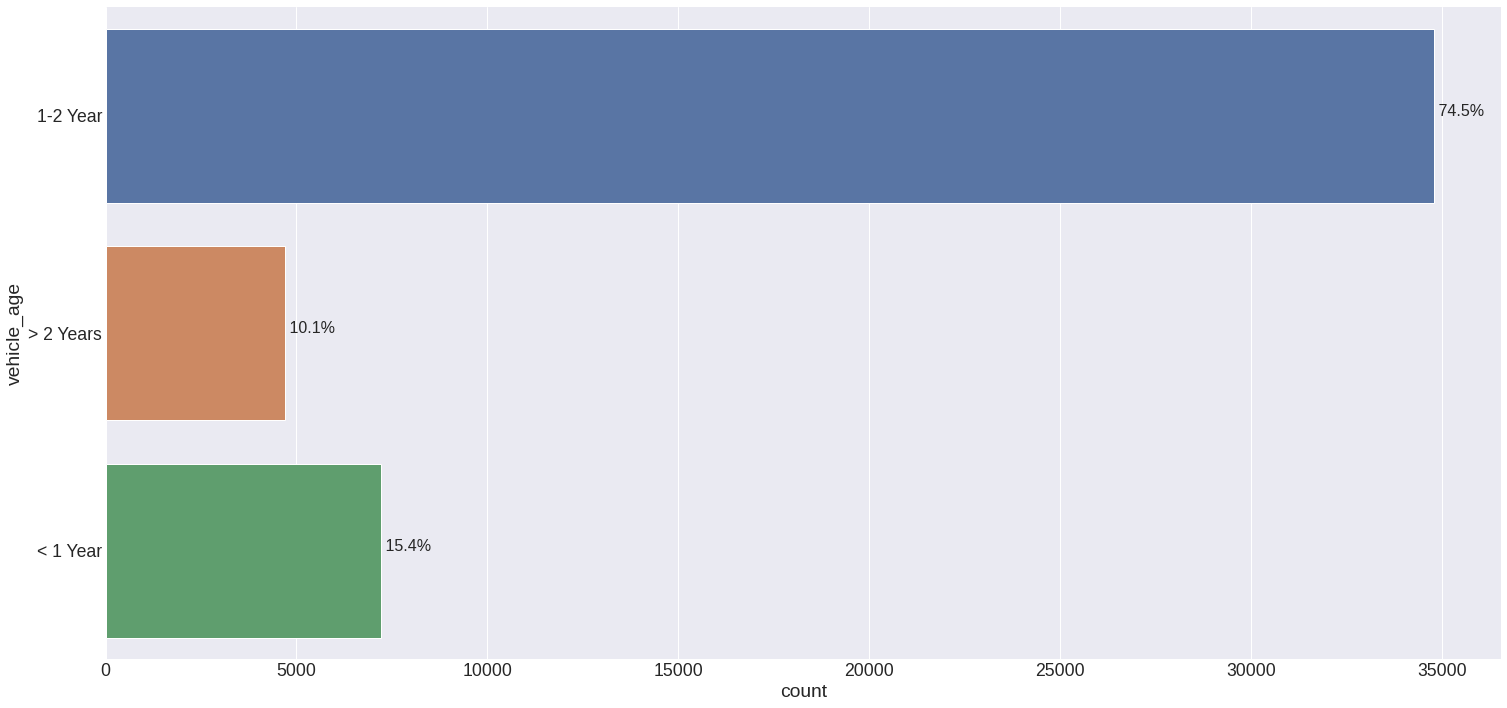

In [44]:
aux1 = df4[df4['response'] == 'yes']
ax = sns.countplot(y='vehicle_age', data=aux1);

total = aux1['vehicle_age'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H6 Less than 40% of customers who have damaged the vehicle don't want to get the health insurance.
**FALSE:** Customers who don't want the health insurance and got damaged are about 43.9%.

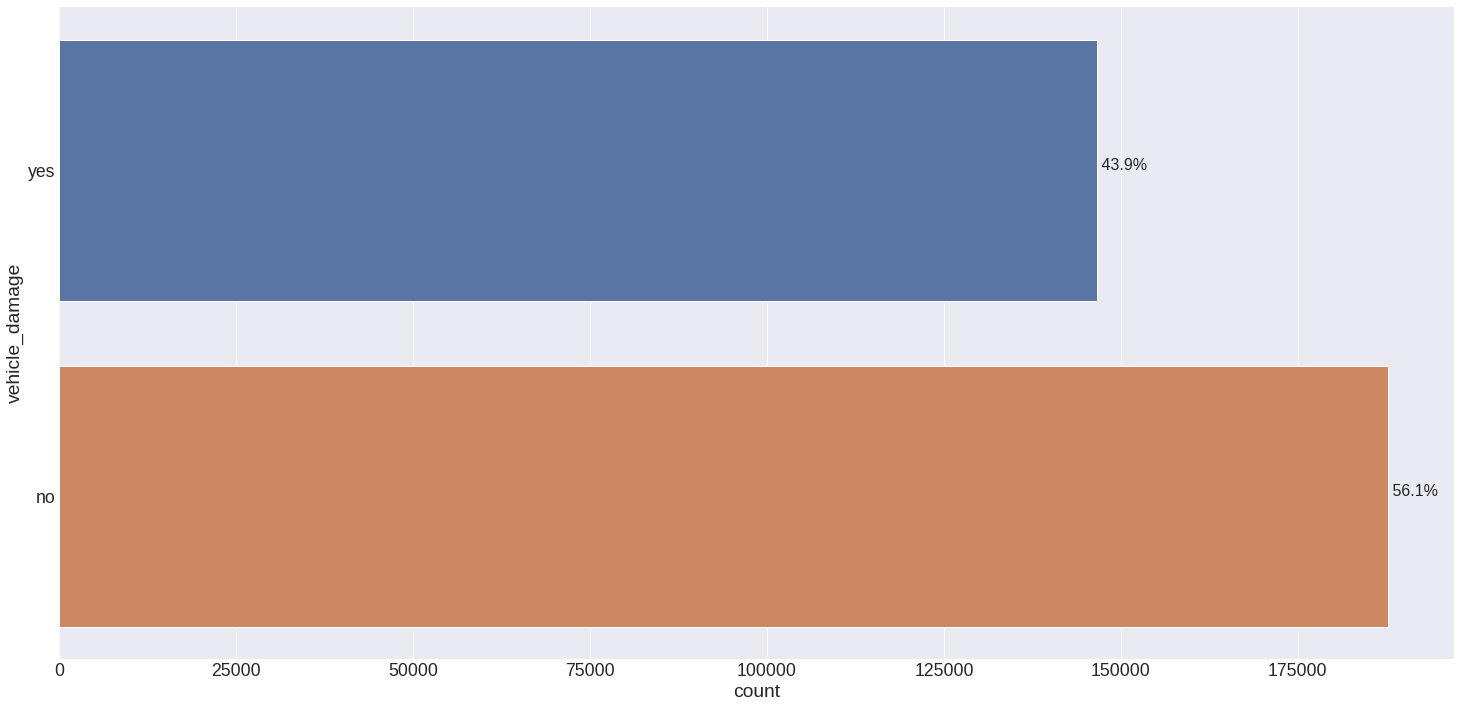

In [45]:
aux1 = df4[df4['response'] == 'no']
ax = sns.countplot(y='vehicle_damage', data=aux1);

total = aux1['vehicle_damage'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H7 Older customers and those which pay more for annual health insurance are more likely to get health insurance.
**FALSE:** There's no different for older customers who pay for annual premium.

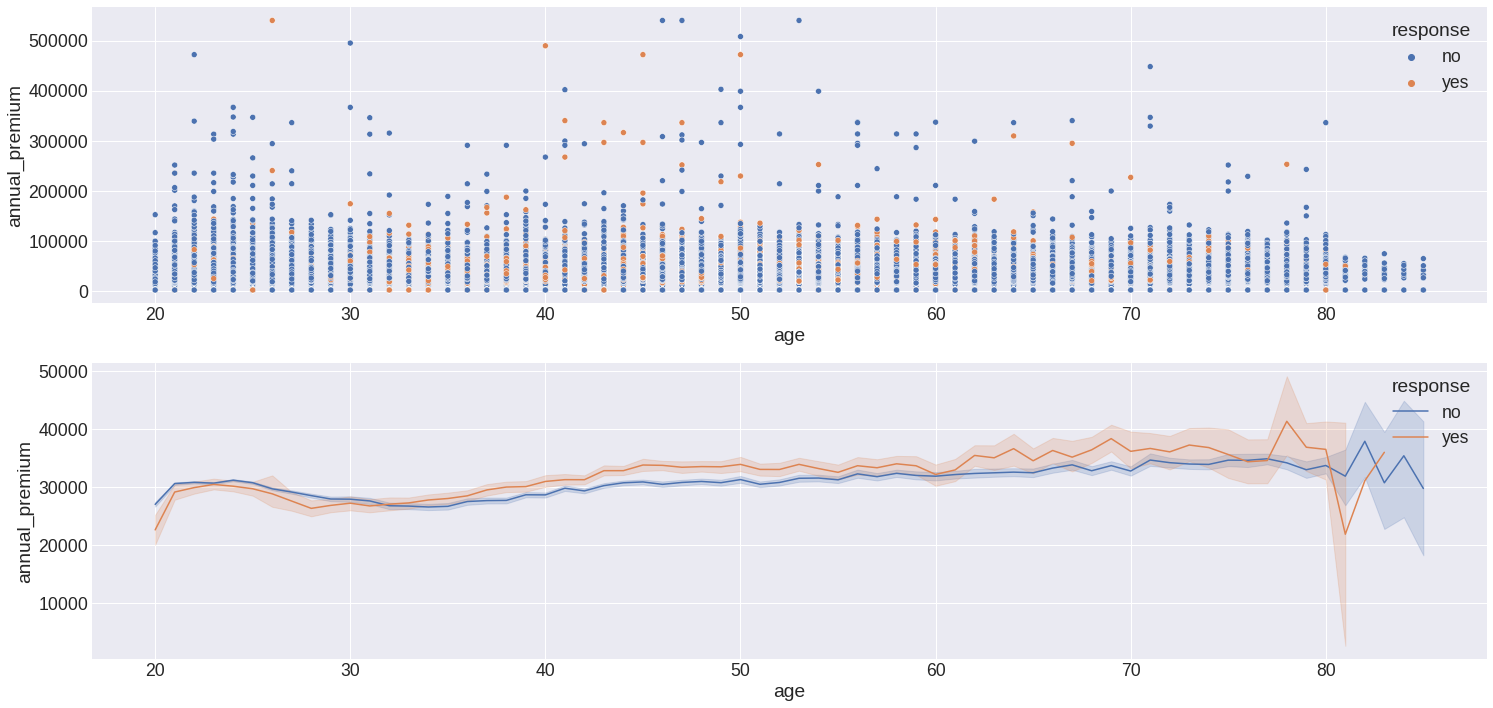

In [46]:
plt.subplot(2, 1, 1)
sns.scatterplot(x='age', y='annual_premium', data=df4, hue='response')

plt.subplot(2, 1, 2)
sns.lineplot(x='age', y='annual_premium', data=df4, hue='response');

### H8 The more time associated, customers are more likely to get the health insurance.
**FALSE:** There is no difference between the number of days.

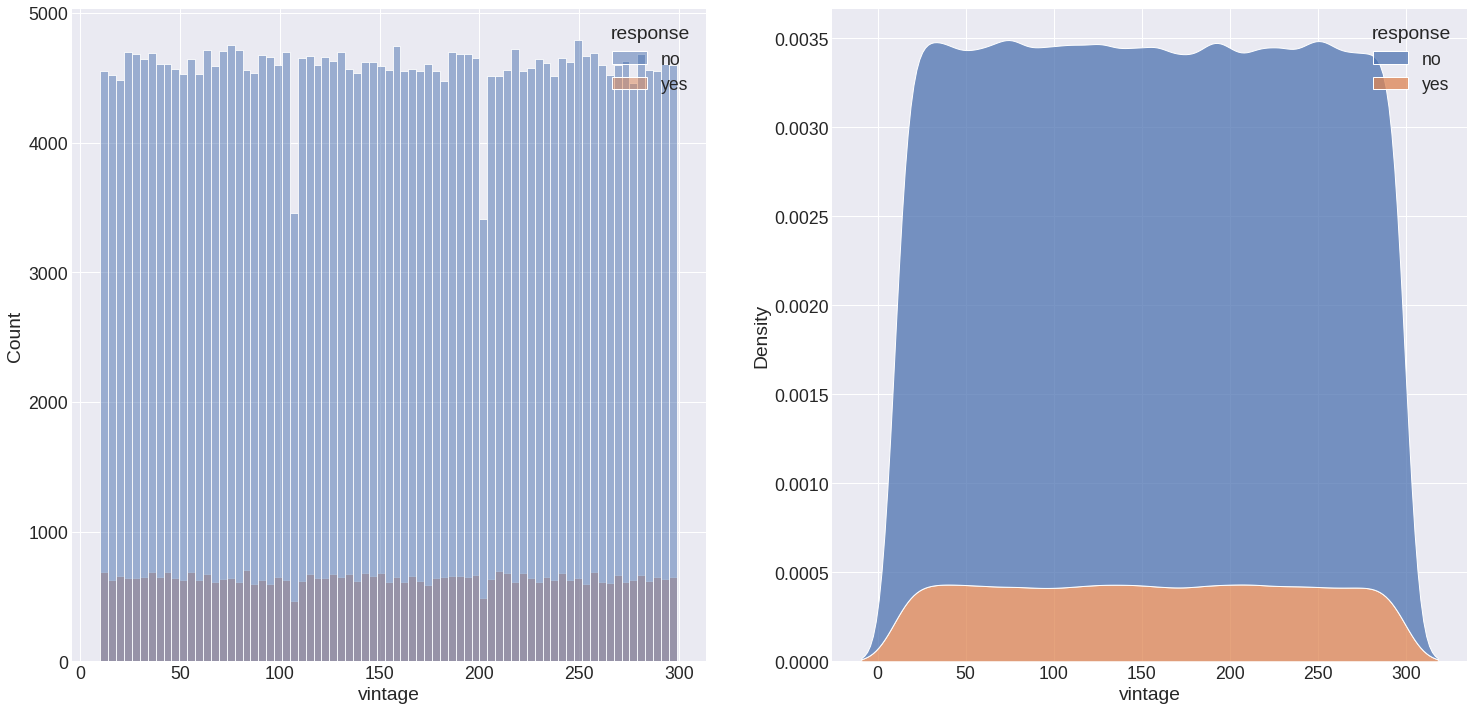

In [47]:
plt.subplot(1, 2, 1)
sns.histplot(x='vintage', data=df4, hue='response')

plt.subplot(1, 2, 2)
sns.kdeplot(x='vintage', data=df4, hue='response', multiple="stack");

## 4.4 Multivariaty Analysis

### 4.4.1 Numerical

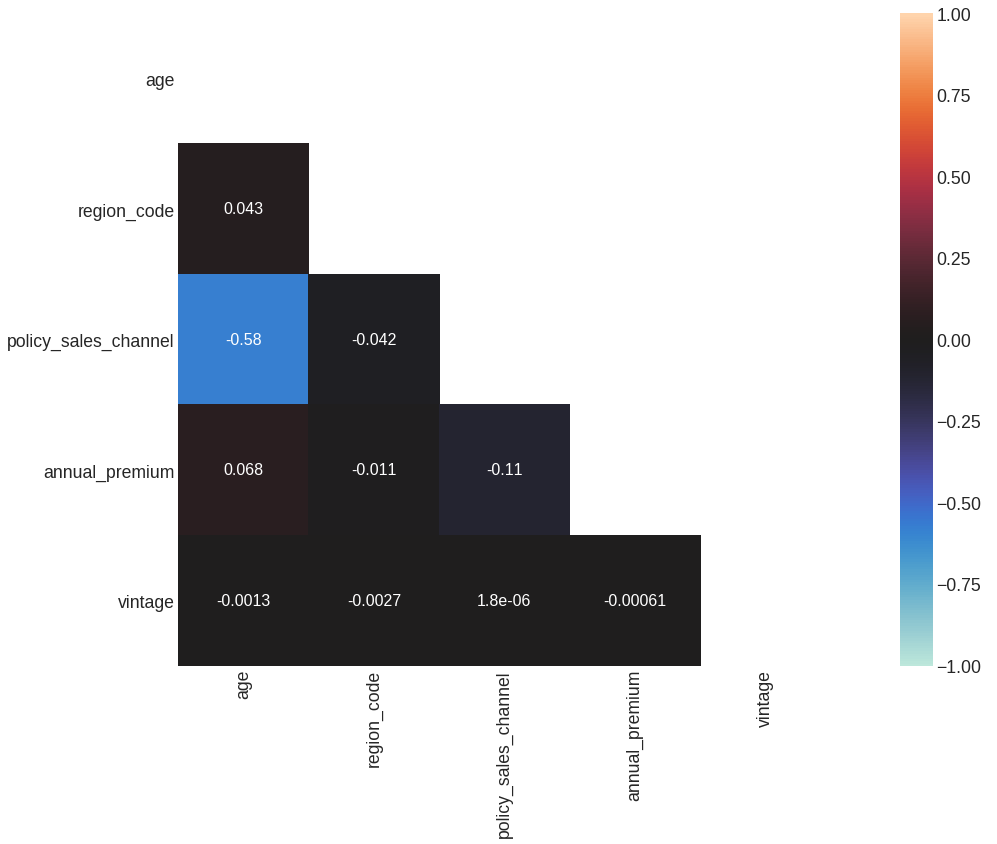

In [48]:
corr = aux1 = df4.select_dtypes(exclude='object').corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

### 4.4.2 Categorical

In [49]:
cat_attributes = df4.select_dtypes(include='object')
dict_corr = {}
columns = cat_attributes.columns.tolist()

for column in columns:
    dict_corr[column] = {}
    
    for column2 in columns:
        dict_corr[column][column2] = calcCramerV(cat_attributes[column], cat_attributes[column2])
        
corr = pd.DataFrame(dict_corr)

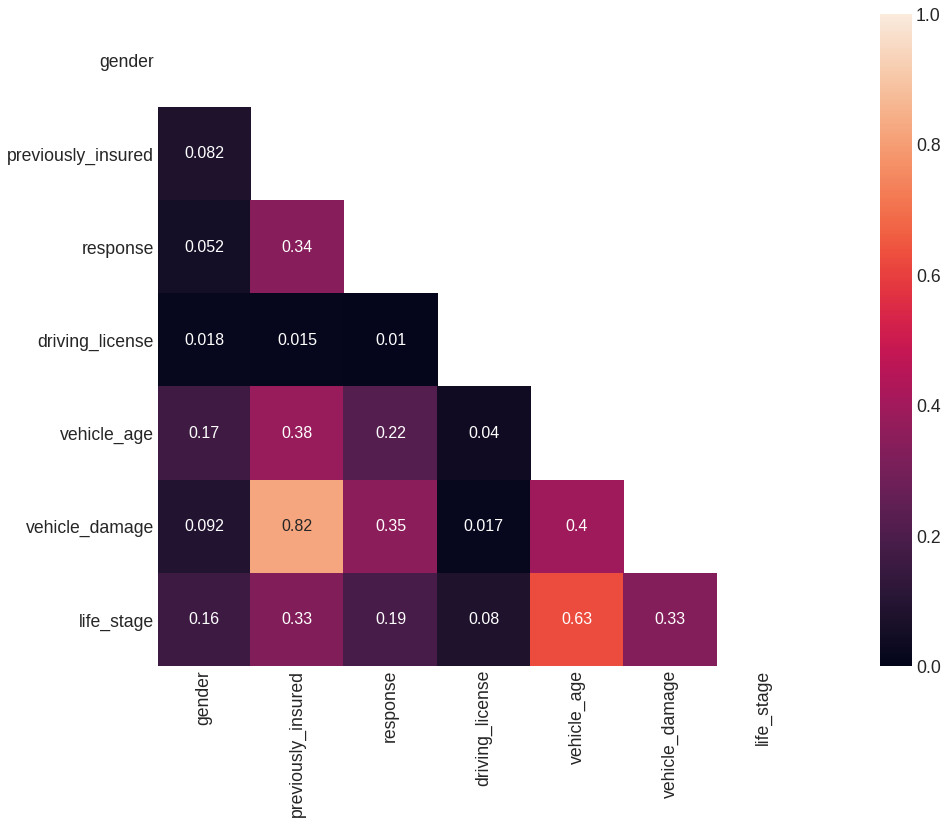

In [50]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

# 5.0 Data Preparation

## 5.1 Loading

In [51]:
df5 = pd.read_csv('../data/interim/data_step03_cycle1.csv')

## 5.2 Spliting into Train, Valid and Test

In [52]:
X = df5.drop(columns='response', axis=1)
y = df5['response'].map({'yes': 1, 'no': 0})

In [53]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp)

## 5.3 Categorical Encoder

### 5.3.1 One Hot Encoder

In [54]:
ohe_columns = ['gender', 'previously_insured', 'driving_license', 'vehicle_damage']
ohe = ce.OneHotEncoder(cols=ohe_columns, use_cat_names=True)

In [55]:
X_params = ohe.fit_transform(X_temp)
X_test = ohe.transform(X_test)

In [56]:
X_train = ohe.fit_transform(X_train)
X_valid = ohe.transform(X_valid)

### 5.3.2 Ordinal Encoder

In [57]:
columns_to = ['vehicle_age','life_stage' ]
oe = ce.OrdinalEncoder(cols=columns_to, 
                       mapping=[
                           {'col': 'vehicle_age', 
                            'mapping': {'< 1 Year': 1, 
                                        '1-2 Year': 2, 
                                        '> 2 Years': 3}
                           },
                           {'col': 'life_stage', 
                            'mapping': {'Adolescence': 4, 
                                        'Early Adulthood': 5, 
                                        'Midlife': 6, 
                                        'Mature Adulthood': 7, 
                                        'Late Adulthood': 8}
                           }
                       ], return_df=False)

columns_to_oe = list(map(lambda i: i + '_oe', columns_to))

X_params[columns_to_oe] = oe.fit_transform(X_params[columns_to])
X_test[columns_to_oe] = oe.transform(X_test[columns_to])

X_train[columns_to_oe] = oe.fit_transform(X_train[columns_to])
X_valid[columns_to_oe] = oe.transform(X_valid[columns_to])

### 5.3.3 Target Encoder

In [58]:
columns_to = ['region_code', 'policy_sales_channel', 'vehicle_age', 'life_stage']
te = ce.TargetEncoder(cols=columns_to, return_df=False)

columns_to_te = list(map(lambda i: i + '_te', columns_to))

X_params[columns_to_te] = te.fit_transform(X_params[columns_to], y_temp)
X_test[columns_to_te] = te.transform(X_test[columns_to])

In [59]:
X_train[columns_to_te] = te.fit_transform(X_train[columns_to], y_train)
X_valid[columns_to_te] = te.transform(X_valid[columns_to])

### 5.3.4 Count Encoder

In [60]:
columns_to = ['region_code', 'policy_sales_channel', 'vehicle_age', 'life_stage']
count = ce.CountEncoder(cols=columns_to, return_df=False)

columns_to_te = list(map(lambda i: i + '_ce', columns_to))

X_params[columns_to_te] = count.fit_transform(X_params[columns_to], y_temp)
X_test[columns_to_te] = count.transform(X_test[columns_to])

## 5.4 Natural Transformation

### 5.4.1 Age

In [61]:
normal_tests(X_params['age'])

,Shapiro,Skew,Kurtosis
default,0.909558,0.673936,-0.564898
boxcox,0.934892,0.062784,-1.347869
sqrt,0.927321,0.427635,-0.985592
cuberoot,0.930471,0.350985,-1.088783
log,0.934890,0.206164,-1.245419


In [62]:
X_params['age_bx'] = stats.boxcox(X_params['age'])[0]
X_test['age_bx'] = stats.boxcox(X_test['age'])[0]

In [63]:
X_train['age_bx'] = stats.boxcox(X_train['age'])[0]
X_valid['age_bx'] = stats.boxcox(X_valid['age'])[0]

### 5.4.2 Annual Premium

In [64]:
normal_tests(X_params['annual_premium'])

,Shapiro,Skew,Kurtosis
default,0.873132,1.797539,35.487730
boxcox,0.885672,0.084927,6.212147
sqrt,0.843820,-0.791440,0.886335
cuberoot,0.800067,-1.102266,0.477954
log,0.700480,-1.466986,0.643143


In [65]:
X_params['annual_premium_sqrt'] = np.sqrt(X_params['annual_premium'])
X_test['annual_premium_sqrt'] = np.sqrt(X_test['annual_premium'])

In [66]:
X_train['annual_premium_sqrt'] = np.sqrt(X_train['annual_premium'])
X_valid['annual_premium_sqrt'] = np.sqrt(X_valid['annual_premium'])

### 5.4.3 Vintage

In [67]:
normal_tests(df5['vintage'])

,Shapiro,Skew,Kurtosis
default,0.955180,0.003030,-1.200688
boxcox,0.956820,-0.227827,-1.080024
sqrt,0.949350,-0.456101,-0.829477
cuberoot,0.936926,-0.649572,-0.515261
log,0.888219,-1.119255,0.630900


In [68]:
X_params['vintage_cuberoot'] = np.power(X_params['vintage'], 1/3)
X_test['vintage_cuberoot'] = np.power(X_test['vintage'], 1/3)

In [69]:
X_train['vintage_cuberoot'] = np.power(X_train['vintage'], 1/3)
X_valid['vintage_cuberoot'] = np.power(X_valid['vintage'], 1/3)

## 5.5 Scaling

### 5.5.1 Standard Scaler

In [70]:
columns_to = columns_to = ['age_bx', 'annual_premium_sqrt', 'vintage_cuberoot']
ss = StandardScaler()

columns_to_ss = list(map(lambda i: i + '_ss', columns_to))

X_params.loc[:, columns_to_ss] = ss.fit_transform(X_params[columns_to])
X_test.loc[:, columns_to_ss] = ss.transform(X_test[columns_to])

X_train.loc[:, columns_to_ss] = ss.fit_transform(X_train[columns_to])
X_valid.loc[:, columns_to_ss] = ss.transform(X_valid[columns_to])

### 5.5.2 MinMax Scaler 

In [71]:
columns_to = columns_to = ['age', 'vintage']
mm = MinMaxScaler()

columns_to_mm = list(map(lambda i: i + '_mm', columns_to))

X_params.loc[:, columns_to_mm] = ss.fit_transform(X_params[columns_to])
X_test.loc[:, columns_to_mm] = ss.transform(X_test[columns_to])

X_train.loc[:, columns_to_mm] = ss.fit_transform(X_train[columns_to])
X_valid.loc[:, columns_to_mm] = ss.transform(X_valid[columns_to])

### 5.5.3 Robust Scaler

In [72]:
columns_to = columns_to = ['annual_premium']
rs = RobustScaler()

columns_to_rs = list(map(lambda i: i + '_rs', columns_to))

X_params.loc[:, columns_to_rs] = ss.fit_transform(X_params[columns_to])
X_test.loc[:, columns_to_rs] = ss.transform(X_test[columns_to])

X_train.loc[:, columns_to_rs] = ss.fit_transform(X_train[columns_to])
X_valid.loc[:, columns_to_rs] = ss.transform(X_valid[columns_to])

## 5.6 Remove Columns

In [73]:
columns_to_drop = ['age', 'region_code', 'policy_sales_channel', 'annual_premium', 'vintage', 'vehicle_age', 
                   'life_stage', 'age_bx', 'annual_premium_sqrt', 'vintage_cuberoot']

X_params.drop(columns=columns_to_drop, axis=1, inplace=True)
X_test.drop(columns=columns_to_drop, axis=1, inplace=True)

X_train.drop(columns=columns_to_drop, axis=1, inplace=True)
X_valid.drop(columns=columns_to_drop, axis=1, inplace=True)

## 5.7 Saves

In [74]:
X_temp['response'] = y_temp.values

X_params['response'] = y_temp.values
X_test['response'] = y_test.values

X_train['response'] = y_train.values
X_valid['response'] = y_valid.values

In [75]:
X_temp.to_csv('../data/interim/data_step05_temp_cycle1.csv', index=False)

X_params.to_csv('../data/interim/data_step05_params_cycle1.csv', index=False)
X_test.to_csv('../data/interim/data_step05_test_cycle1.csv', index=False)

X_train.to_csv('../data/interim/data_step05_train_cycle1.csv', index=False)
X_valid.to_csv('../data/interim/data_step05_valid_cycle1.csv', index=False)

# 6.0 Feature Selection

## 6.1 Loading

In [77]:
df6_temp = pd.read_csv('../data/interim/data_step05_temp_cycle1.csv')

df6_params = pd.read_csv('../data/interim/data_step05_params_cycle1.csv')
df6_test = pd.read_csv('../data/interim/data_step05_test_cycle1.csv')

df6_train = pd.read_csv('../data/interim/data_step05_train_cycle1.csv')
df6_valid = pd.read_csv('../data/interim/data_step05_valid_cycle1.csv')

In [107]:
X_temp, y_temp = df6_temp.iloc[:, :-1], df6_temp.iloc[:, -1]

X_params, y_params = df6_params.iloc[:, :-1], df6_params.iloc[:, -1]
X_test, y_test = df6_test.iloc[:, :-1], df6_test.iloc[:, -1]

X_train, y_train = df6_train.iloc[:, :-1], df6_train.iloc[:, -1]
X_valid, y_valid = df6_valid.iloc[:, :-1], df6_valid.iloc[:, -1]

## 6.2 Boruta + Extra Trees

In [79]:
# X_boruta = X_params.values
# y_boruta = y_params.values.ravel()

In [80]:
# etc = ExtraTreesClassifier(class_weight='balanced', n_jobs=3)

# boruta = BorutaPy(etc, n_estimators='auto')
# boruta.fit(X_boruta, y_boruta)

In [81]:
# cols_selected_boruta = boruta.support_.tolist()
# columns_selected = X_params.loc[:, cols_selected_boruta].columns.tolist()

# columns_selected

In [82]:
columns_selected_ext = ['previously_insured_yes', 'previously_insured_no', 'vehicle_damage_no',
                        'vehicle_damage_yes', 'policy_sales_channel_te', 'age_bx_ss', 'age_mm']

## 6.3 SelectFromModel + Extra Tree

In [83]:
# etc = ExtraTreesClassifier(n_jobs=3, class_weight='balanced')
# sfm = SelectFromModel(etc)

# sfm.fit(X_params, y_params)

In [84]:
# cols_selected_sfm = sfm.get_support()
# columns_selected = X_params.loc[:, cols_selected_sfm].columns.tolist()

# columns_selected

In [85]:
columns_selected_rf = ['previously_insured_yes', 'previously_insured_no', 'vehicle_damage_no',
                       'vehicle_damage_yes', 'region_code_te', 'region_code_ce', 'age_bx_ss',
                       'annual_premium_sqrt_ss', 'vintage_cuberoot_ss', 'age_mm', 'vintage_mm',
                       'annual_premium_rs']

## 6.4 Feature Importances + Extra Tree

In [86]:
etc = ExtraTreesClassifier(n_jobs=3, class_weight='balanced')
etc.fit(X_params, y_params)

ExtraTreesClassifier(class_weight='balanced', n_jobs=3)

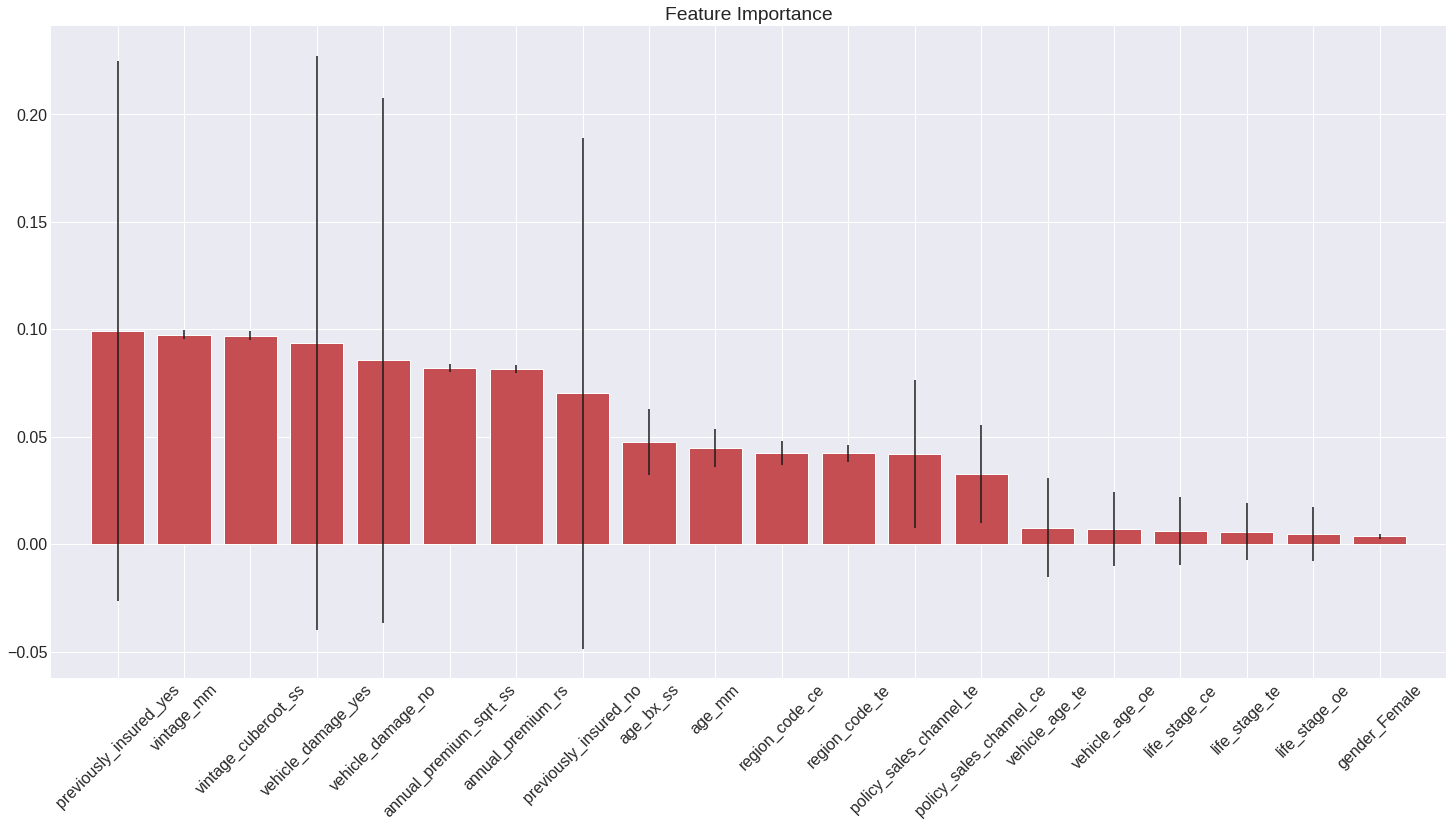

In [87]:
skplt.estimators.plot_feature_importances(etc, feature_names=X_params.columns.tolist());
plt.xticks(rotation=45);

In [88]:
columns_selected_fi = ['vehicle_damage_yes', 'vintage_mm', 'vintage_cuberoot_ss', 'previously_insured_no', 
                       'annual_premium_sqrt_ss', 'annual_premium_rs', 'annual_premium_rs', 'vehicle_damage_no']

## 6.5 Saves

In [153]:
cs = ['previously_insured_yes', 'previously_insured_no', 'vehicle_damage_no',
      'vehicle_damage_yes', 'policy_sales_channel_te', 'age_bx_ss', 'age_mm']

X_temp_cs = X_temp[['previously_insured', 'vehicle_damage', 'policy_sales_channel', 'age']]

X_params_cs = X_params[cs]
X_test_cs = X_test[cs]

X_train_cs = X_train[cs]
X_valid_cs = X_valid[cs]

In [154]:
X_temp_cs['response'] = y_temp.values

X_params_cs['response'] = y_params.values
X_test_cs['response'] = y_test.values

X_train_cs['response'] = y_train.values
X_valid_cs['response'] = y_valid.values

In [155]:
X_temp_cs.to_csv('../data/interim/data_step06_temp_cycle1.csv', index=False)

X_params_cs.to_csv('../data/processed/data_step06_params_cycle1.csv', index=False)
X_test_cs.to_csv('../data/interim/data_step06_test_cycle1.csv', index=False)

X_train_cs.to_csv('../data/interim/data_step06_train_cycle1.csv', index=False)
X_valid_cs.to_csv('../data/interim/data_step06_valid_cycle1.csv', index=False)

# 7.0 Machine Learning Modeling

## 7.1 Loading

In [28]:
df7_params = pd.read_csv('../data/processed/data_step06_params_cycle1.csv')
df7_test = pd.read_csv('../data/interim/data_step06_test_cycle1.csv')

df7_train = pd.read_csv('../data/interim/data_step06_train_cycle1.csv')
df7_valid = pd.read_csv('../data/interim/data_step06_valid_cycle1.csv')

df7_temp = pd.read_csv('../data/interim/data_step06_temp_cycle1.csv')

In [29]:
X_params, y_params = df7_params.iloc[:, :-1], df7_params.iloc[:, -1]
X_test, y_test = df7_test.iloc[:, :-1], df7_test.iloc[:, -1]

X_train, y_train = df7_train.iloc[:, :-1], df7_train.iloc[:, -1]
X_valid, y_valid = df7_valid.iloc[:, :-1], df7_valid.iloc[:, -1]

X_temp, y_temp = df7_temp.iloc[:, :-1], df7_temp.iloc[:, -1]

## 7.2 Baseline Model

In [41]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)

y_prob = dummy.predict_proba(X_valid)

### 7.2.1 Results

In [42]:
k = int(y_valid.shape[0] / 2)

In [43]:
dummy_results = ml_top_k_scores('Dummy', y_valid, y_prob, k=k)
dummy_results

,Precision_at_k,Recall_at_k,F1_at_k
Dummy,0.1215,0.4956,0.1951


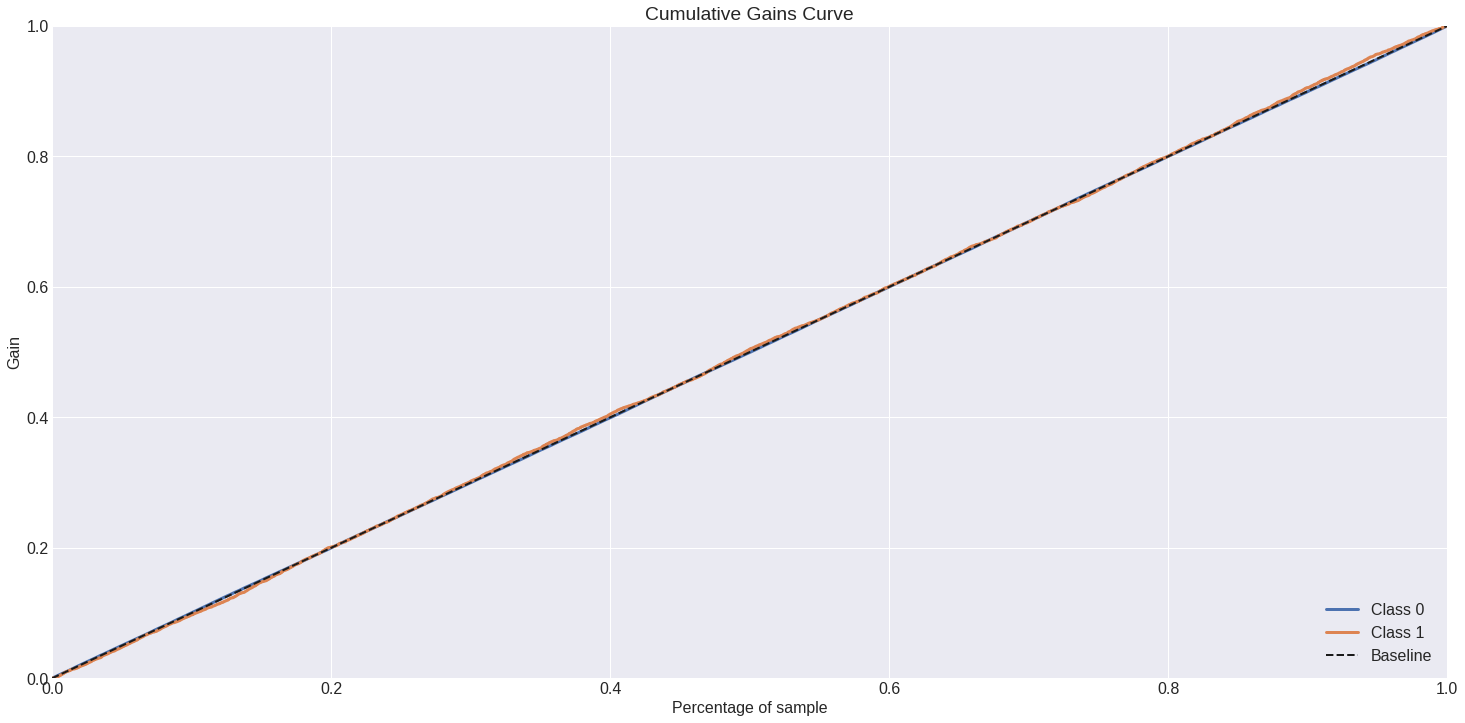

In [44]:
skplt.metrics.plot_cumulative_gain(y_valid, y_prob);

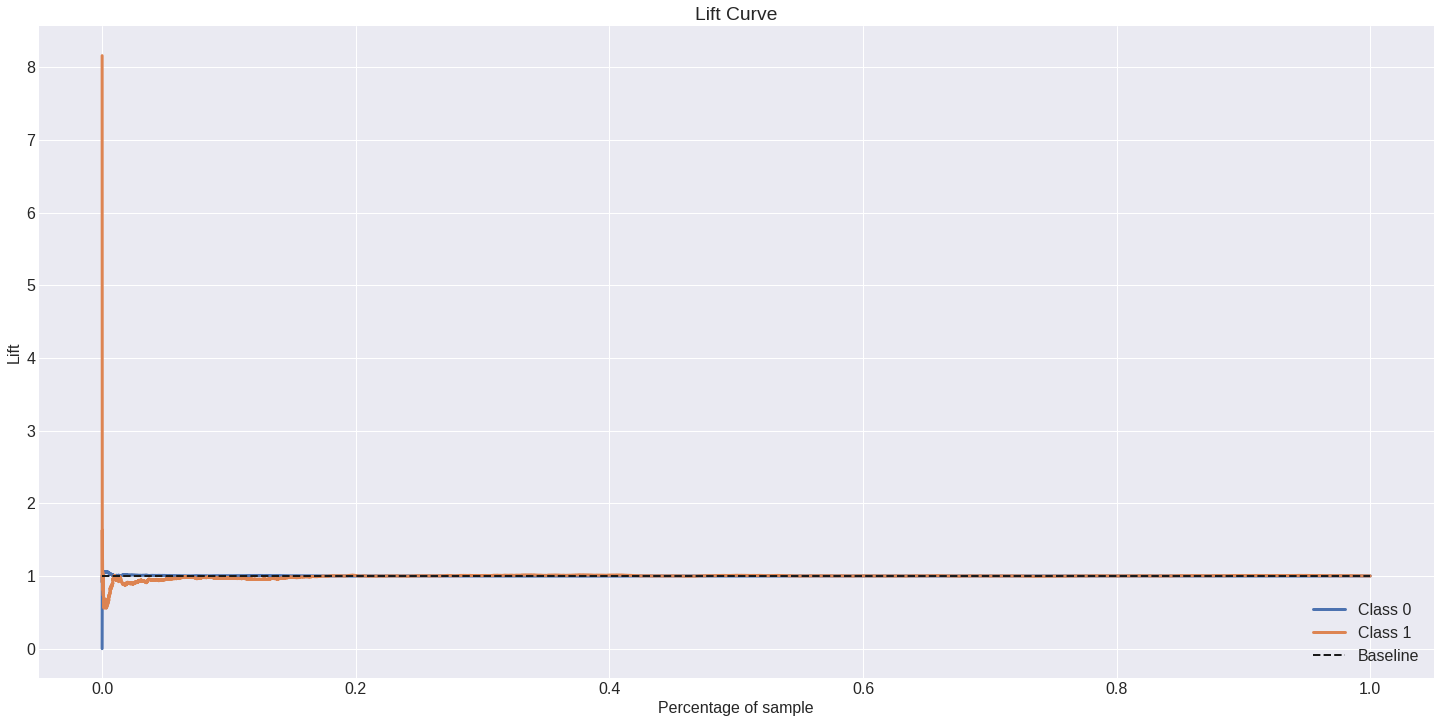

In [45]:
skplt.metrics.plot_lift_curve(y_valid, y_prob);

### 7.2.2 Cross Validation

In [46]:
dummy_cv = ml_cv_results('Dummy', DummyClassifier(), X_temp, y_temp)
dummy_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Precision_at_k,Recall_at_k,F1_at_k
Dummy,0.1231 +/- 0.0015,0.5021 +/- 0.0059,0.1977 +/- 0.0023


## 7.3 Logistic Regression

In [59]:
lg = LogisticRegression(class_weight='balanced')
lg.fit(X_train, y_train)

y_prob = lg.predict_proba(X_valid)

### 7.3.1 Results

In [60]:
k = int(y_valid.shape[0] / 2)

lg_results = ml_top_k_scores('Logistic Regression', y_valid, y_prob, k=k)
lg_results

,Precision_at_k,Recall_at_k,F1_at_k
Logistic Regression,0.2417,0.986,0.3882


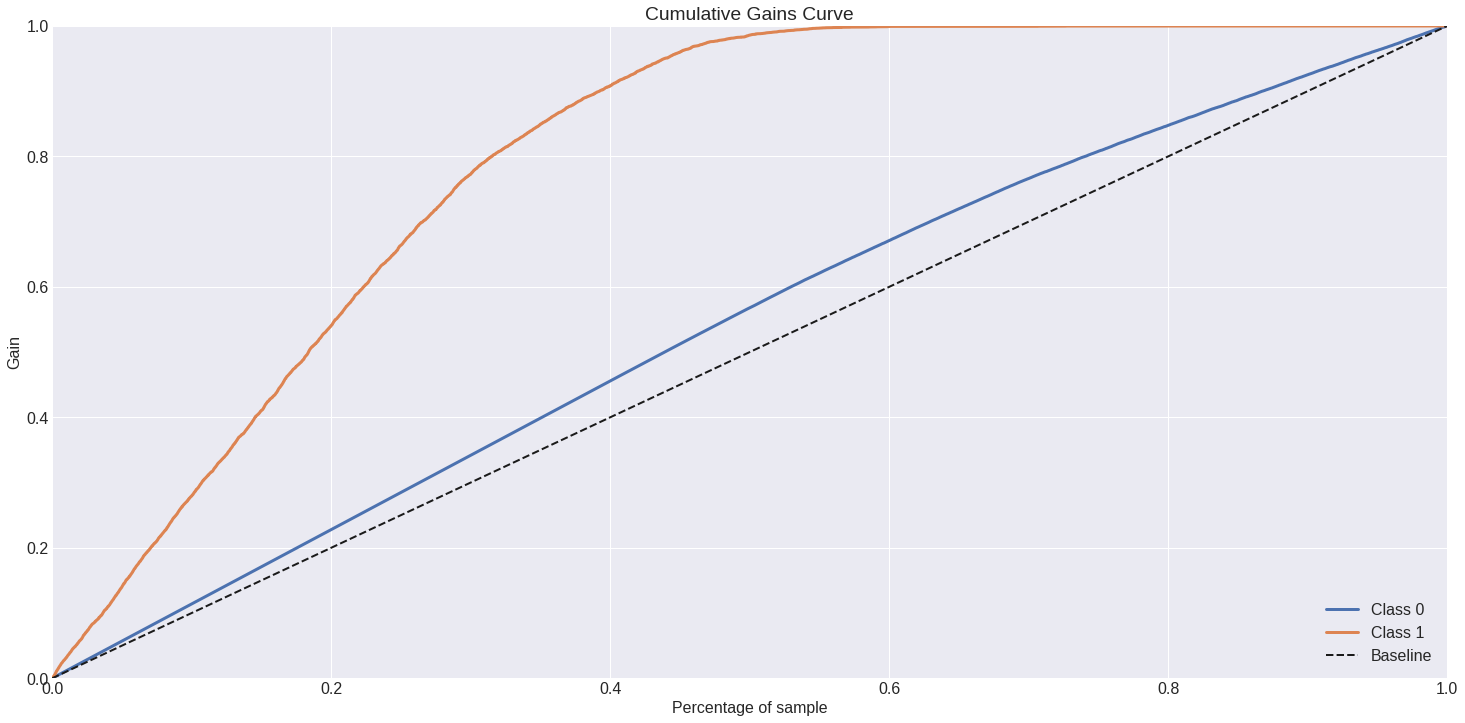

In [61]:
skplt.metrics.plot_cumulative_gain(y_valid, y_prob);

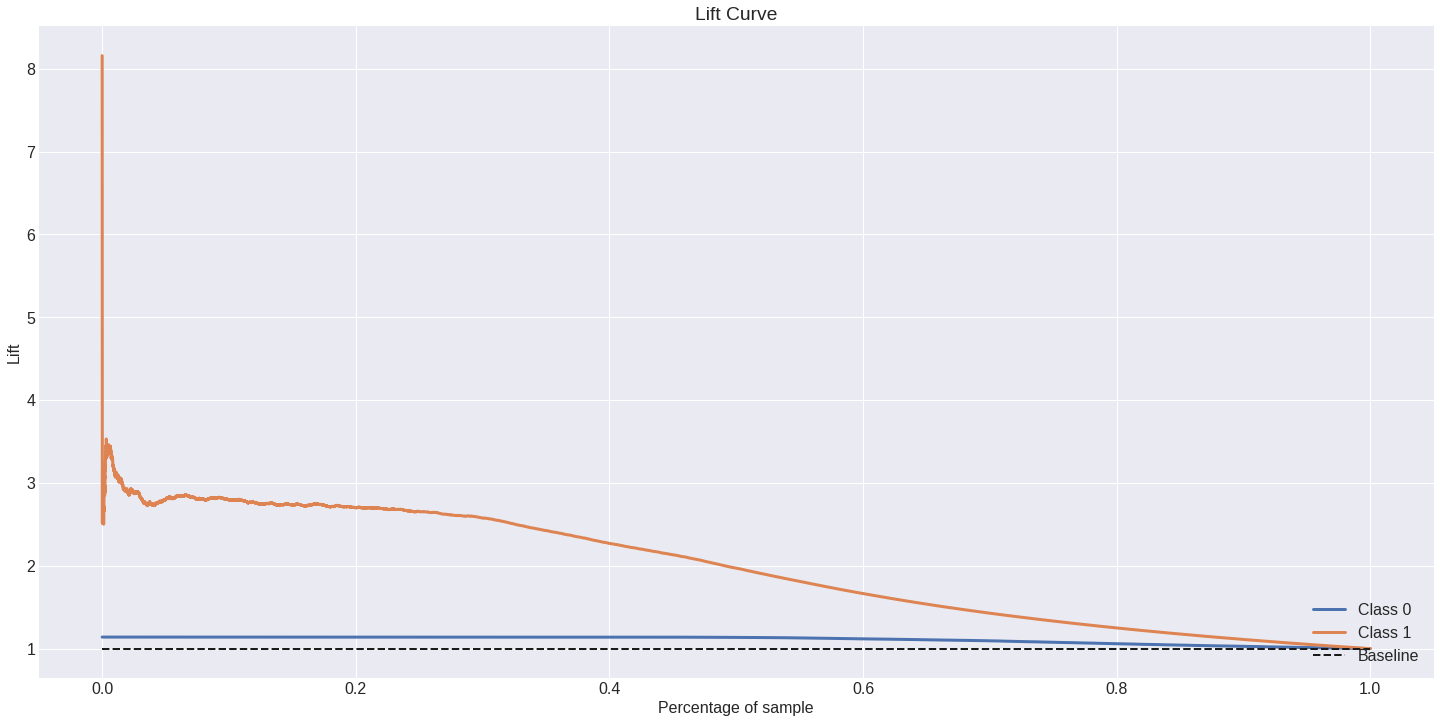

In [62]:
skplt.metrics.plot_lift_curve(y_valid, y_prob);

### 7.3.2 Cros Validation

In [63]:
lg_cv = ml_cv_results('Logistic Regression', LogisticRegression(class_weight='balanced'), X_temp, y_temp)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Precision_at_k,Recall_at_k,F1_at_k
Logistic Regression,0.242 +/- 0.0002,0.9874 +/- 0.0009,0.3888 +/- 0.0003


## 7.4 Random Forest

In [64]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)

y_prob = rf.predict_proba(X_valid)

### 7.4.1 Results

In [66]:
rf_results = ml_top_k_scores('Random Forest', y_valid, y_prob, k=k)
rf_results

,Precision_at_k,Recall_at_k,F1_at_k
Random Forest,0.24,0.9793,0.3856


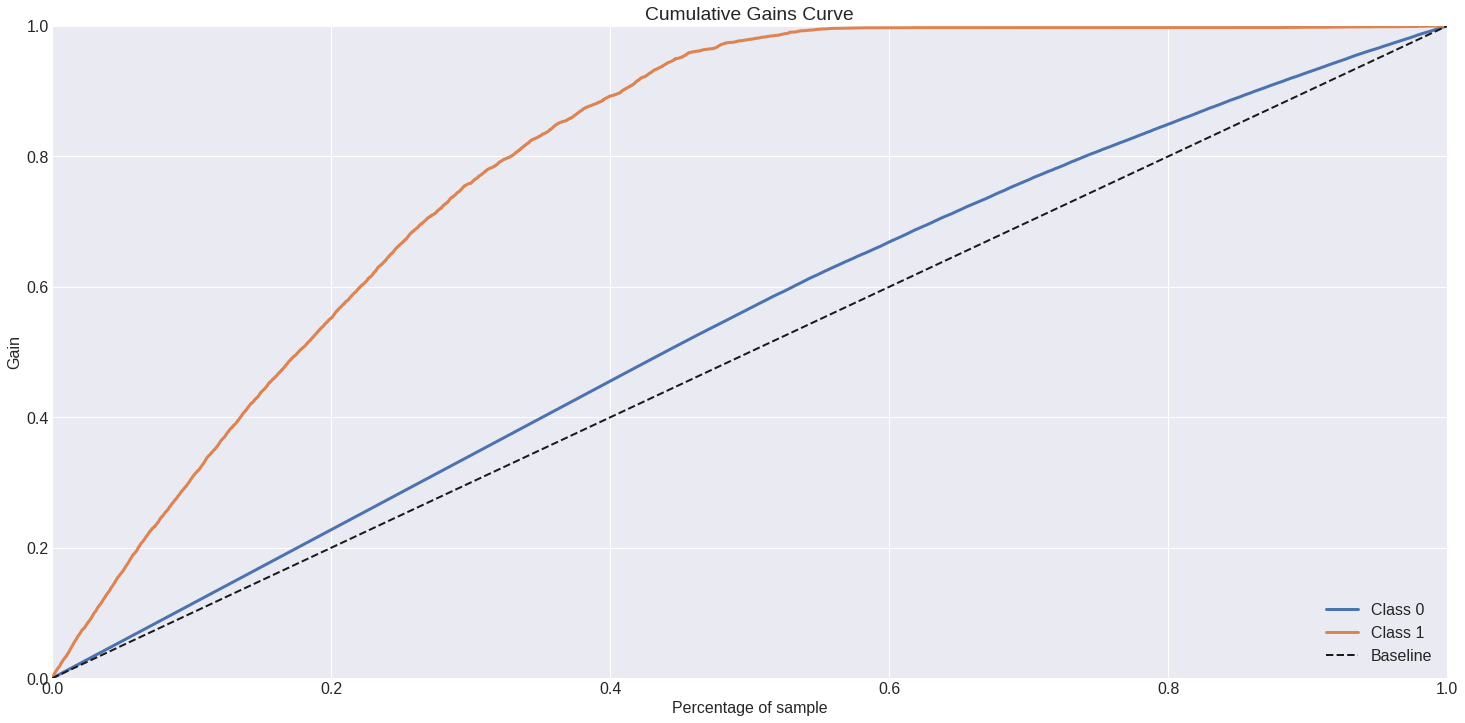

In [67]:
skplt.metrics.plot_cumulative_gain(y_valid, y_prob);

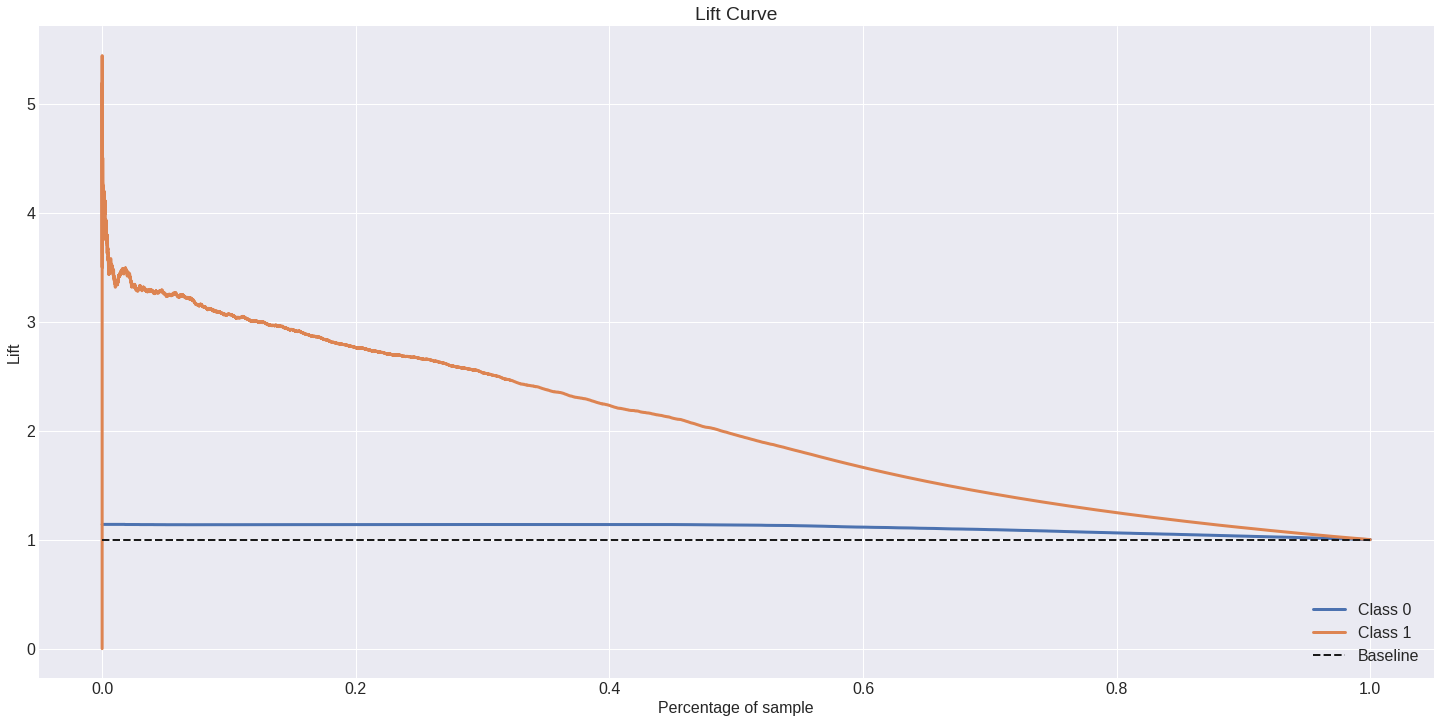

In [68]:
skplt.metrics.plot_lift_curve(y_valid, y_prob);

### 7.4.2 Cross Validation

In [69]:
rf_cv = ml_cv_results('Random Forest', RandomForestClassifier(class_weight='balanced'), X_temp, y_temp)
rf_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Precision_at_k,Recall_at_k,F1_at_k
Random Forest,0.2406 +/- 0.0003,0.9816 +/- 0.0014,0.3865 +/- 0.0005


## 7.5 Extra Trees

In [70]:
ext = ExtraTreesClassifier(class_weight='balanced')
ext.fit(X_train, y_train)

y_prob = ext.predict_proba(X_valid)

### 7.5.1 Result

In [72]:
ext_results = ml_top_k_scores('Extra Trees', y_valid, y_prob, k=k)
ext_results

,Precision_at_k,Recall_at_k,F1_at_k
Extra Trees,0.2402,0.9801,0.3859


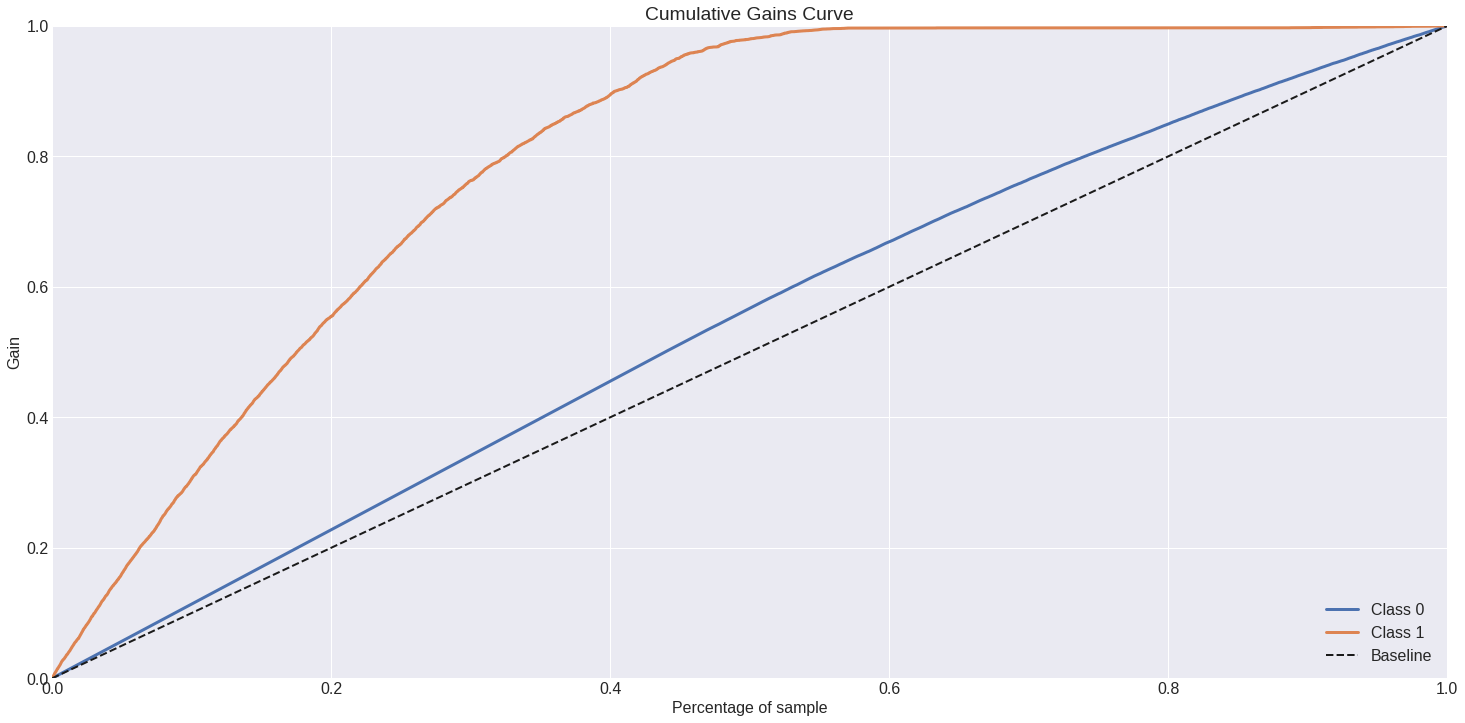

In [73]:
skplt.metrics.plot_cumulative_gain(y_valid, y_prob);

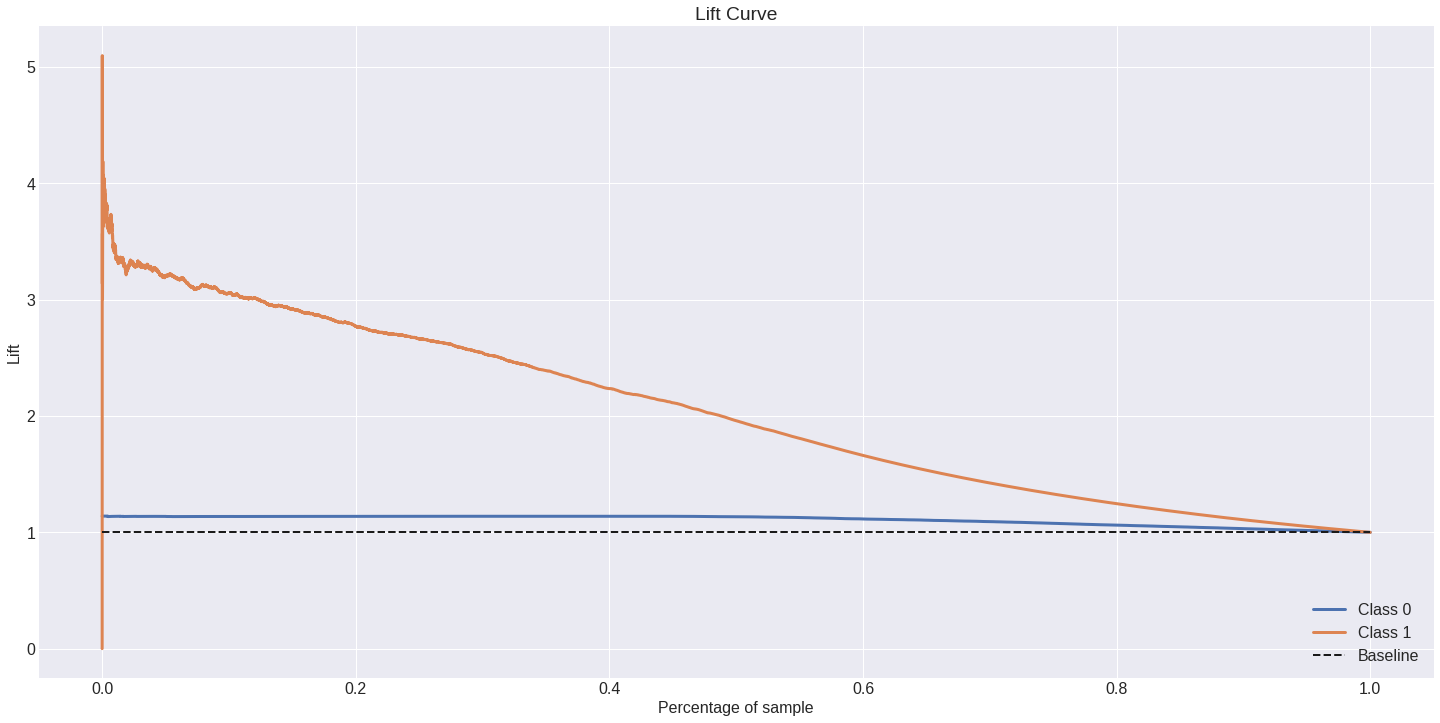

In [74]:
skplt.metrics.plot_lift_curve(y_valid, y_prob);

### 7.5.2 Cross Validation

In [75]:
ext_cv = ml_cv_results('Extra Trees', ExtraTreesClassifier(class_weight='balanced'), X_temp, y_temp)
ext_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Precision_at_k,Recall_at_k,F1_at_k
Extra Trees,0.2406 +/- 0.0004,0.9815 +/- 0.0017,0.3864 +/- 0.0006


## 7.6 XGBoost

In [76]:
xgb = XGBClassifier(class_pos_weight=267519/37368)
xgb.fit(X_train, y_train)

y_prob = xgb.predict_proba(X_valid)

[11:39:50] WARNING: ../src/learner.cc:541: 
Parameters: { class_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:39:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### 7.6.1 Results

In [77]:
xgb_results = ml_top_k_scores('XGBoost', y_valid, y_prob, k=k)
xgb_results

,Precision_at_k,Recall_at_k,F1_at_k
XGBoost,0.2404,0.9806,0.3861


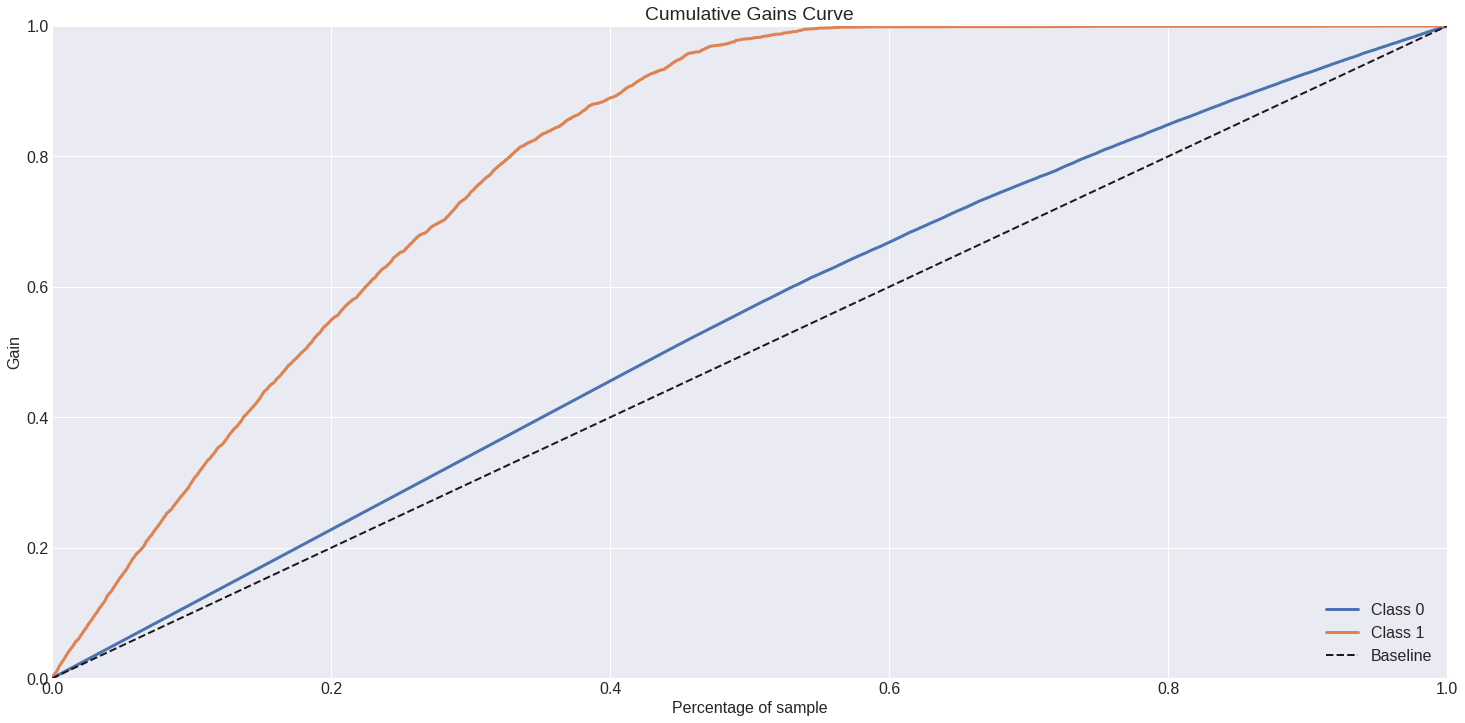

In [78]:
skplt.metrics.plot_cumulative_gain(y_valid, y_prob);

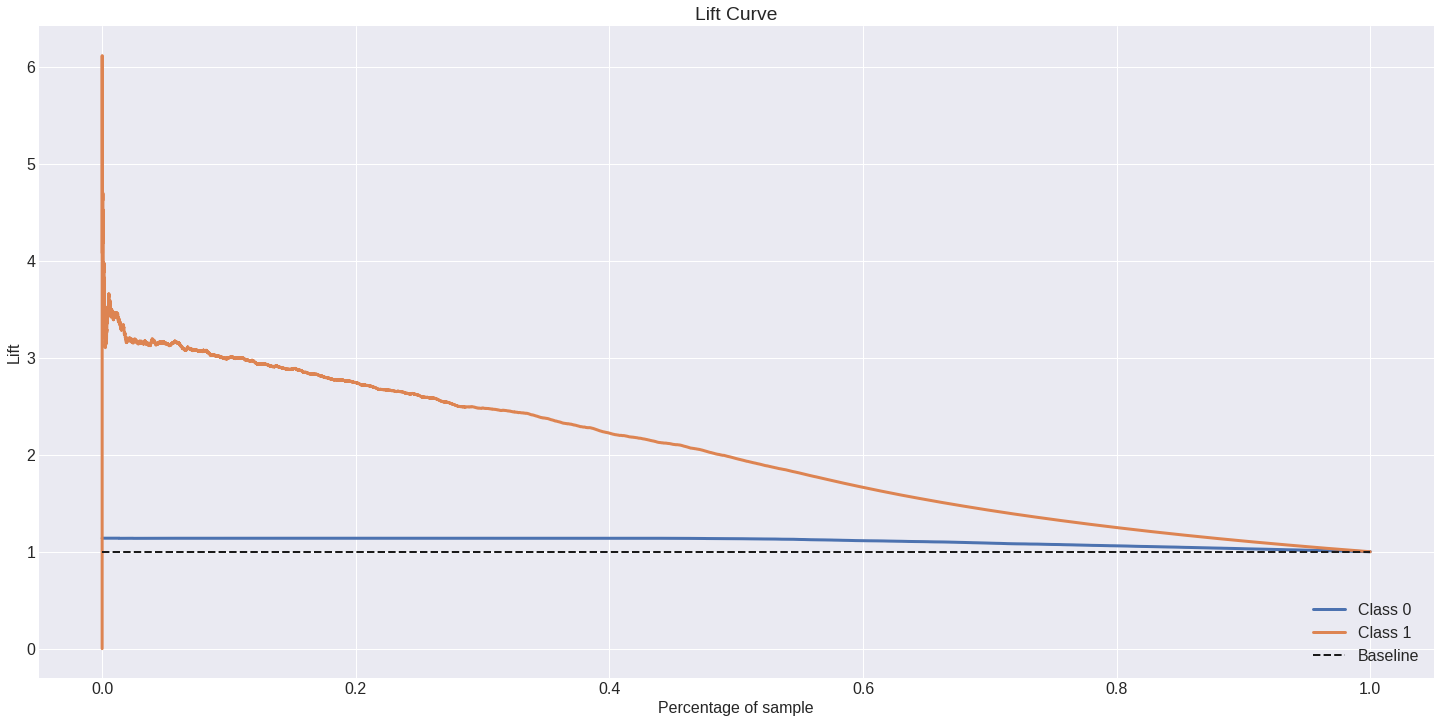

In [79]:
skplt.metrics.plot_lift_curve(y_valid, y_prob);

### 7.6.2 Cross Validation

In [80]:
xgb_cv = ml_cv_results('XGBoost', XGBClassifier(class_pos_weight=267519/37368), X_temp, y_temp)
xgb_cv

Fold K=1
[11:40:02] WARNING: ../src/learner.cc:541: 
Parameters: { class_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:40:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold K=2
[11:40:12] WARNING: ../src/learner.cc:541: 
Parameters: { class_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:40:12] WARNING: ../src/learner.cc:1061: Starting in XG

,Precision_at_k,Recall_at_k,F1_at_k
XGBoost,0.2415 +/- 0.0006,0.9851 +/- 0.0024,0.3879 +/- 0.001


## 7.7 LightGBM

In [81]:
lgbm = LGBMClassifier(class_weight='balanced')
lgbm.fit(X_train, y_train)

y_prob = lgbm.predict_proba(X_valid)

### 7.7.1 Results

In [82]:
lgbm_results = ml_top_k_scores('LightGBM', y_valid, y_prob, k=k)
lgbm_results

,Precision_at_k,Recall_at_k,F1_at_k
LightGBM,0.2417,0.9861,0.3883


### 7.7.2 Cross Validation

In [83]:
lgbm_cv = ml_cv_results('LightGBM', LGBMClassifier(class_weight='balanced'), X_temp, y_temp)
lgbm_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Precision_at_k,Recall_at_k,F1_at_k
LightGBM,0.2417 +/- 0.0002,0.9861 +/- 0.0009,0.3883 +/- 0.0003


## 7.8 Comparing Model's Performance

### 7.8.1 Single Performance

In [84]:
modeling_performance = pd.concat([dummy_results, lg_results, rf_results, ext_results, xgb_results, lgbm_results])
modeling_performance.sort_values(by="Precision_at_k", ascending=True)

,Precision_at_k,Recall_at_k,F1_at_k
Dummy,0.1215,0.4956,0.1951
Random Forest,0.2400,0.9793,0.3856
Extra Trees,0.2402,0.9801,0.3859
XGBoost,0.2404,0.9806,0.3861
Logistic Regression,0.2417,0.9860,0.3882
LightGBM,0.2417,0.9861,0.3883


### 7.8.2 Cross Validation Performance

In [85]:
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, rf_cv, ext_cv, xgb_cv, lgbm_cv])
modeling_performance_cv.sort_values(by="Precision_at_k", ascending=True)

,Precision_at_k,Recall_at_k,F1_at_k
Dummy,0.1231 +/- 0.0015,0.5021 +/- 0.0059,0.1977 +/- 0.0023
Random Forest,0.2406 +/- 0.0003,0.9816 +/- 0.0014,0.3865 +/- 0.0005
Extra Trees,0.2406 +/- 0.0004,0.9815 +/- 0.0017,0.3864 +/- 0.0006
XGBoost,0.2415 +/- 0.0006,0.9851 +/- 0.0024,0.3879 +/- 0.001
LightGBM,0.2417 +/- 0.0002,0.9861 +/- 0.0009,0.3883 +/- 0.0003
Logistic Regression,0.242 +/- 0.0002,0.9874 +/- 0.0009,0.3888 +/- 0.0003


# 8.0 Hyperparameter Fine Tuning

## 8.1 Loading

In [86]:
df8_params = pd.read_csv('../data/processed/data_step06_params_cycle1.csv')
df8_train = pd.read_csv('../data/interim/data_step06_train_cycle1.csv')

df8_valid = pd.read_csv('../data/interim/data_step06_valid_cycle1.csv')
df8_temp = pd.read_csv('../data/interim/data_step06_temp_cycle1.csv')

In [87]:
X_params, y_params = df8_params.iloc[:, :-1], df8_params.iloc[:, -1]
X_train, y_train = df8_train.iloc[:, :-1], df8_train.iloc[:, -1]

X_valid, y_valid = df8_valid.iloc[:, :-1], df8_valid.iloc[:, -1]
X_temp, y_temp = df8_temp.iloc[:, :-1], df8_temp.iloc[:, -1]

## 8.2 Logistic Regression + GridSearch

In [88]:
# f1 = mtr.make_scorer(mtr.recall_score)

In [89]:
# params = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#     'class_weight': ['balanced'],
#     'max_iter': [100, 500, 1000]
# }

In [90]:
# lg_gs = GridSearchCV(
#     LogisticRegression(), 
#     param_grid=params, 
#     scoring=f1, 
#     cv=StratifiedKFold(n_splits=5)
# )

# lg_gs.fit(X_params, y_params)

In [91]:
# best_params = lg_gs.best_params_
# best_params

In [60]:
best_params = {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 100}

In [93]:
lg_gs = LogisticRegression(
    C=best_params['C'], 
    class_weight=best_params['class_weight'], 
    max_iter=best_params['max_iter']
)

lg_gs.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight='balanced')

In [94]:
y_prob = lg_gs.predict_proba(X_valid)

### 8.2.1 Results

In [96]:
k = int(0.5 * y_valid.shape[0])

lg_gs = ml_top_k_scores('Linear Regression GS', y_valid, y_prob, k=k)
lg_gs

,Precision_at_k,Recall_at_k,F1_at_k
Linear Regression GS,0.2411,0.9837,0.3873


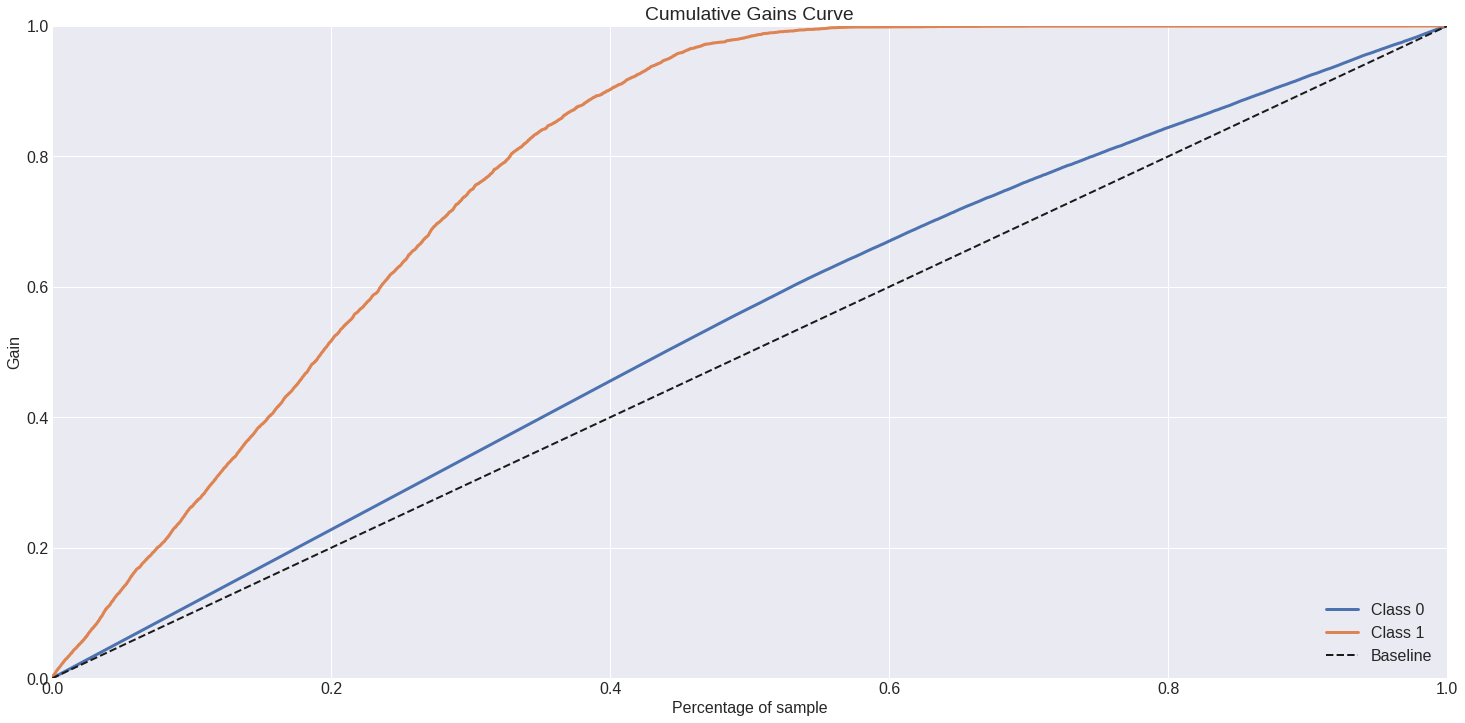

In [97]:
skplt.metrics.plot_cumulative_gain(y_valid, y_prob);

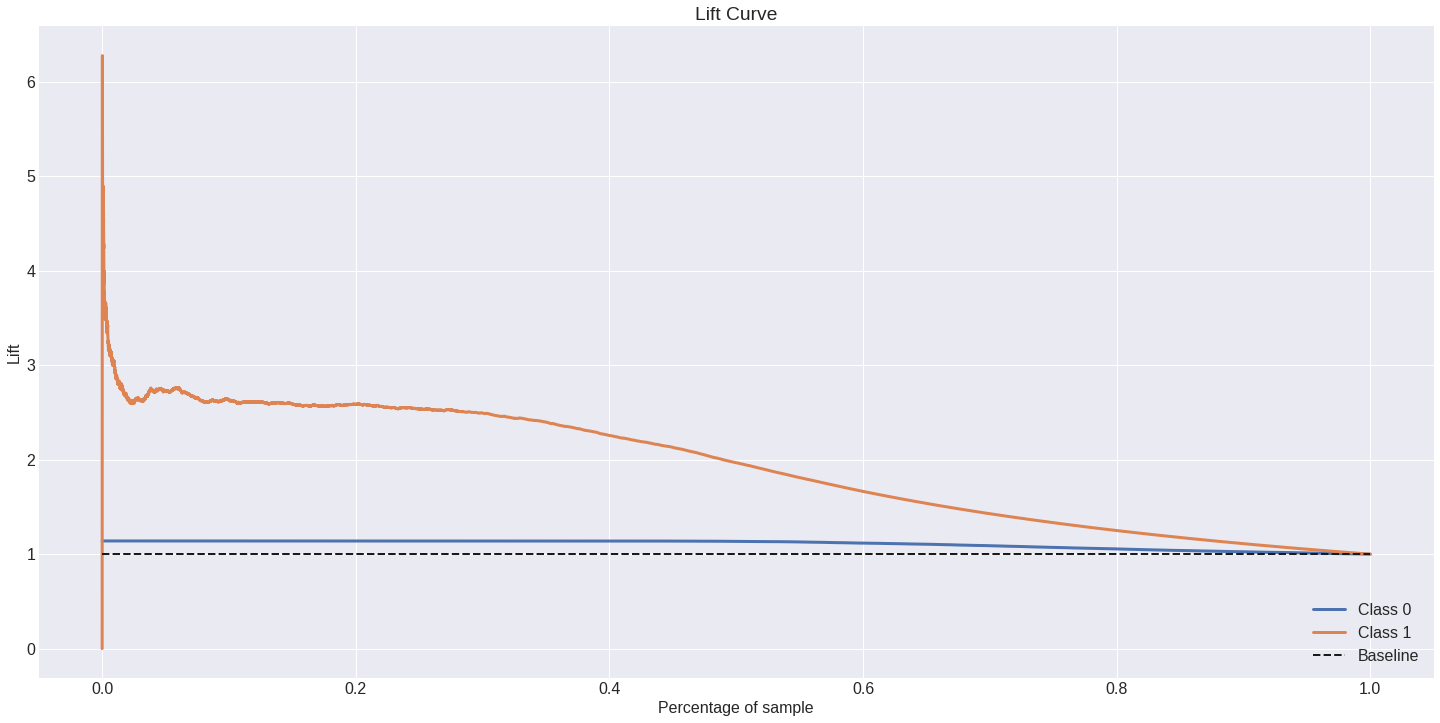

In [98]:
skplt.metrics.plot_lift_curve(y_valid, y_prob);

### 8.2.2 Cross Validation

In [99]:
lg_gs = LogisticRegression(
    C=best_params['C'], 
    class_weight=best_params['class_weight'], 
    max_iter=best_params['max_iter']
)

lg_gs_cv = ml_cv_results('Logistic Regression GS', lg_gs, X_temp, y_temp)
lg_gs_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Precision_at_k,Recall_at_k,F1_at_k
Logistic Regression GS,0.241 +/- 0.0004,0.9831 +/- 0.0016,0.3871 +/- 0.0006


# 9.0 Conclusions

## 9.1 Loading

In [57]:
df4 = pd.read_csv('../data/interim/data_step03_cycle1.csv')

df9_params = pd.read_csv('../data/processed/data_step06_params_cycle1.csv')
df9_test = pd.read_csv('../data/interim/data_step06_test_cycle1.csv')

In [58]:
X_params, y_params = df9_params.iloc[:, :-1], df9_params.iloc[:, -1]
X_test, y_test = df9_test.iloc[:, :-1], df9_test.iloc[:, -1]

## 9.2 Final Model

In [61]:
final_model = LogisticRegression(
    C=best_params['C'], 
    class_weight=best_params['class_weight'], 
    max_iter=best_params['max_iter']
)

final_model.fit(X_params, y_params)

LogisticRegression(C=0.001, class_weight='balanced')

### 9.2.1 Unseen Data Result

In [115]:
y_prob = final_model.predict_proba(X_test)

In [116]:
final_model_score = ml_top_k_scores('Linear Regression GS', y_test, y_prob, k=k)
final_model_score

,Precision_at_k,Recall_at_k,F1_at_k
Linear Regression GS,0.2793,0.9115,0.4275


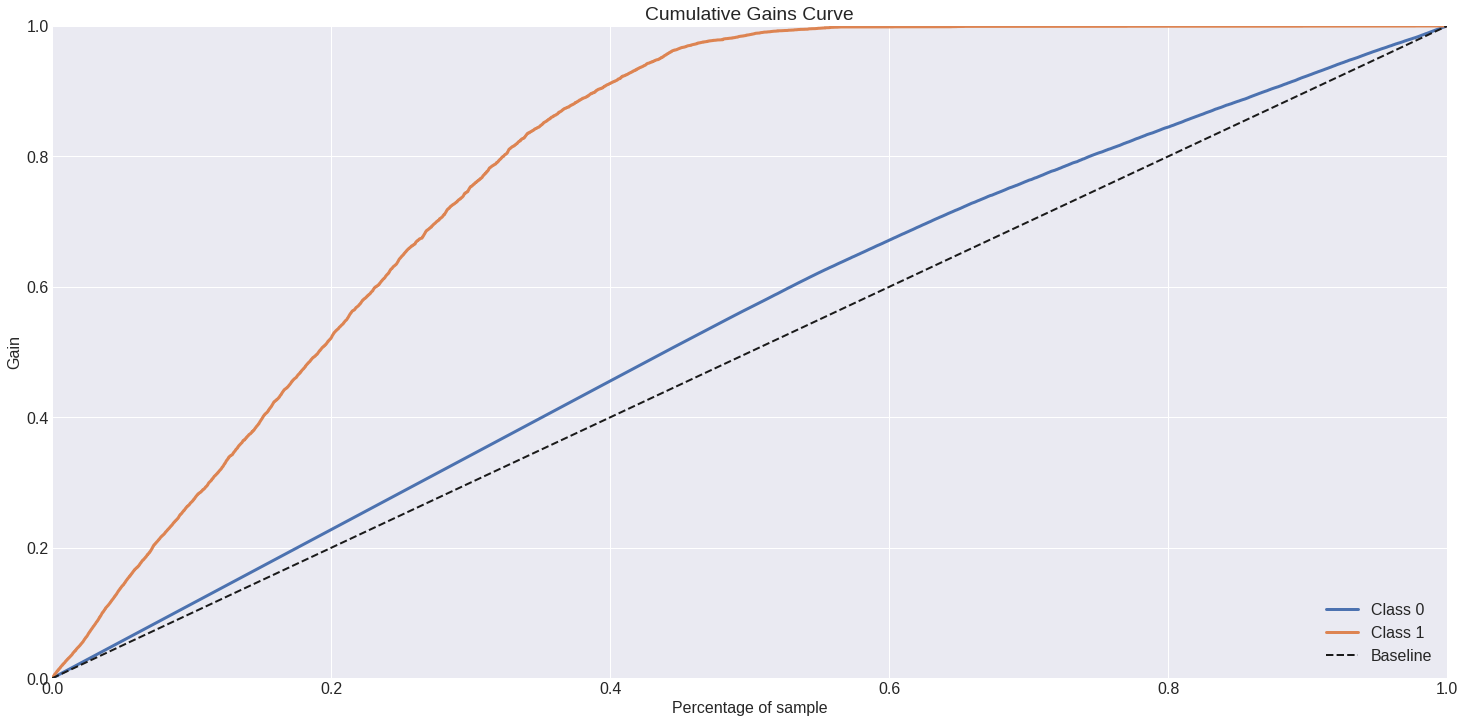

In [117]:
skplt.metrics.plot_cumulative_gain(y_test, y_prob);

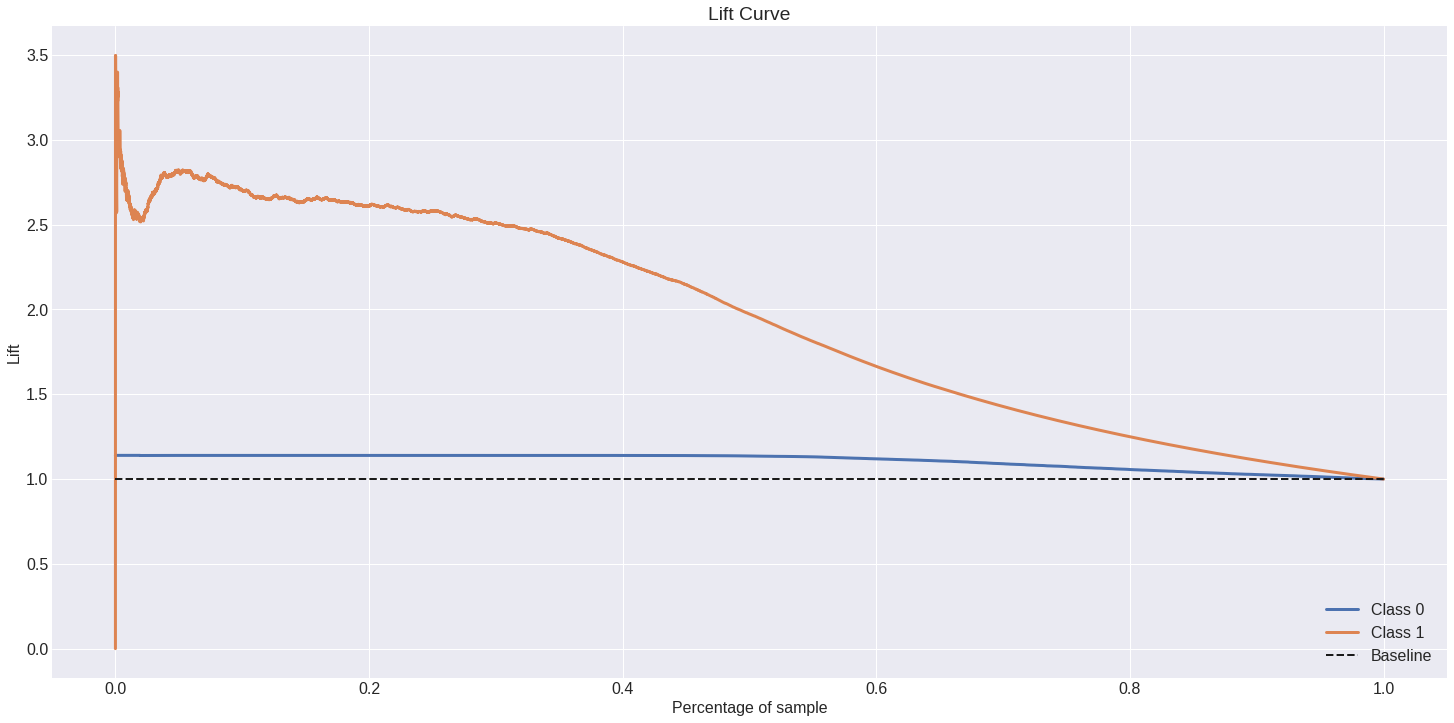

In [118]:
skplt.metrics.plot_lift_curve(y_test, y_prob);

## 9.3 Business Questions

### 9.3.1 What are the main insights on the most relevant attributes of relevant customers in purchasing auto insurance.

#### Early Adulthood and adolescent are about 26.1% of the customers who want the health insurance. The mildlife customers are more likely to get health insurance, they are about 48.3%.

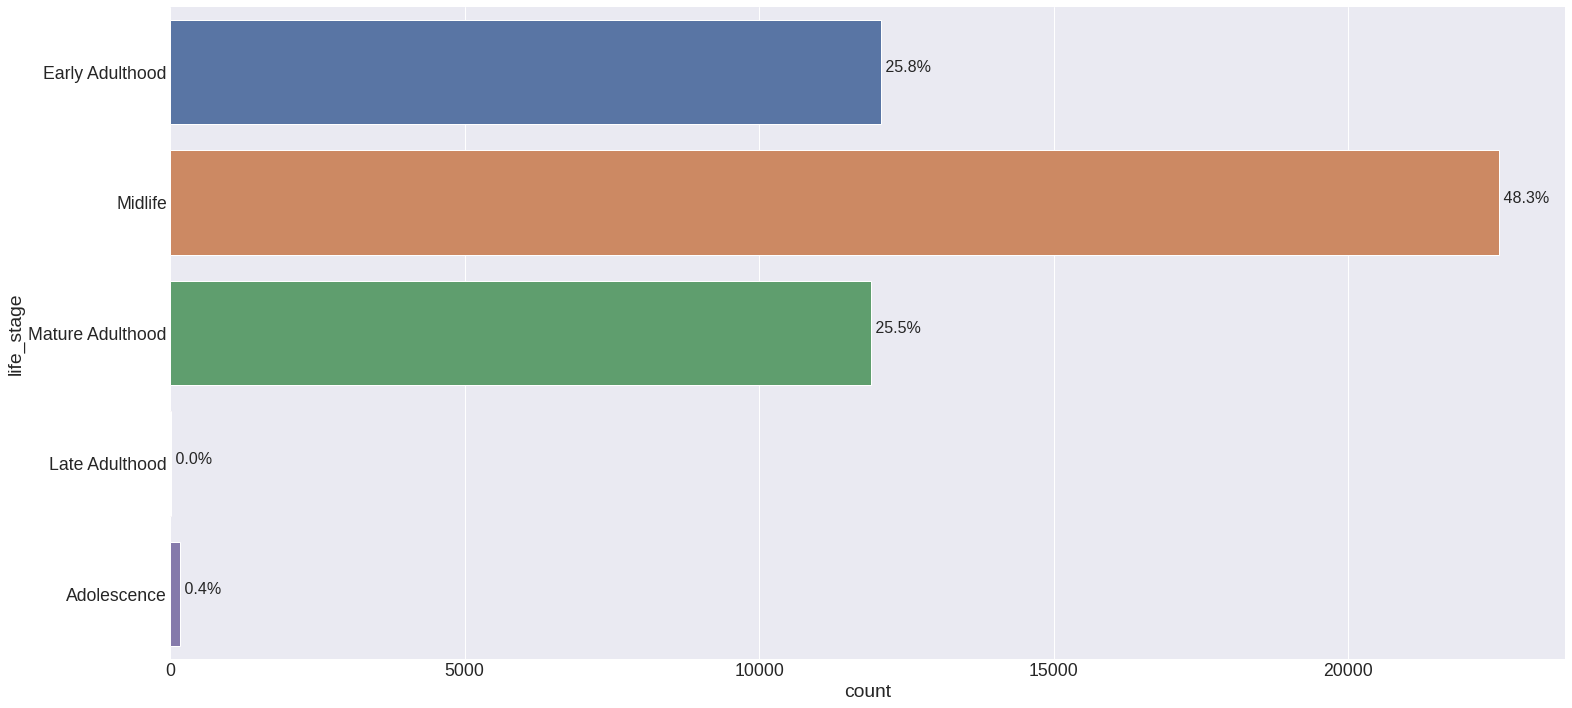

In [119]:
aux1 = df4[df4['response'] == 'yes']
ax = sns.countplot(y='life_stage', data=aux1)

total = aux1['life_stage'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

#### Customers without car insurance are more likely to get health insurance. In this database 99.7% of customers are previously insured.

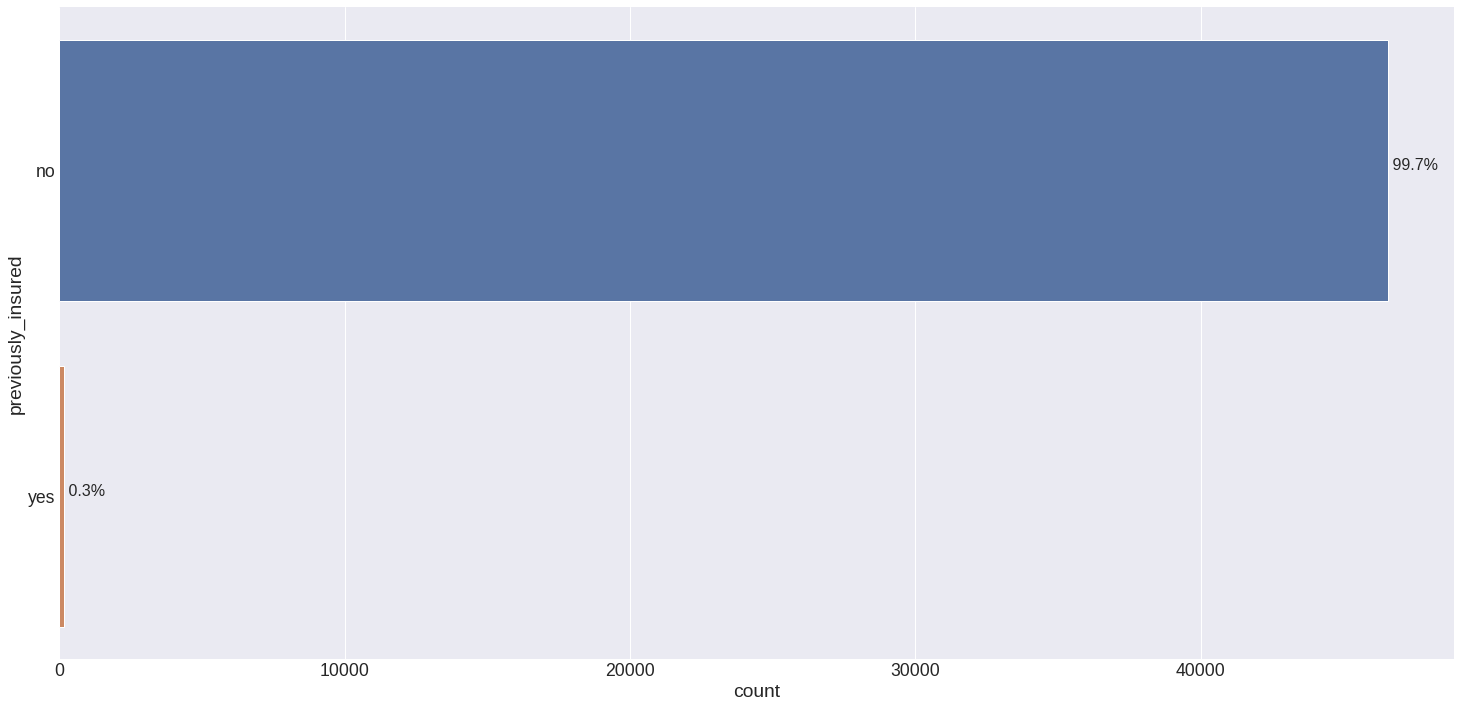

In [120]:
aux1 = df4[df4['response'] == 'yes']
ax = sns.countplot(y='previously_insured', data=aux1);

total = aux1['previously_insured'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

#### Customers who don't want the health insurance and got damaged are about 43.9%.

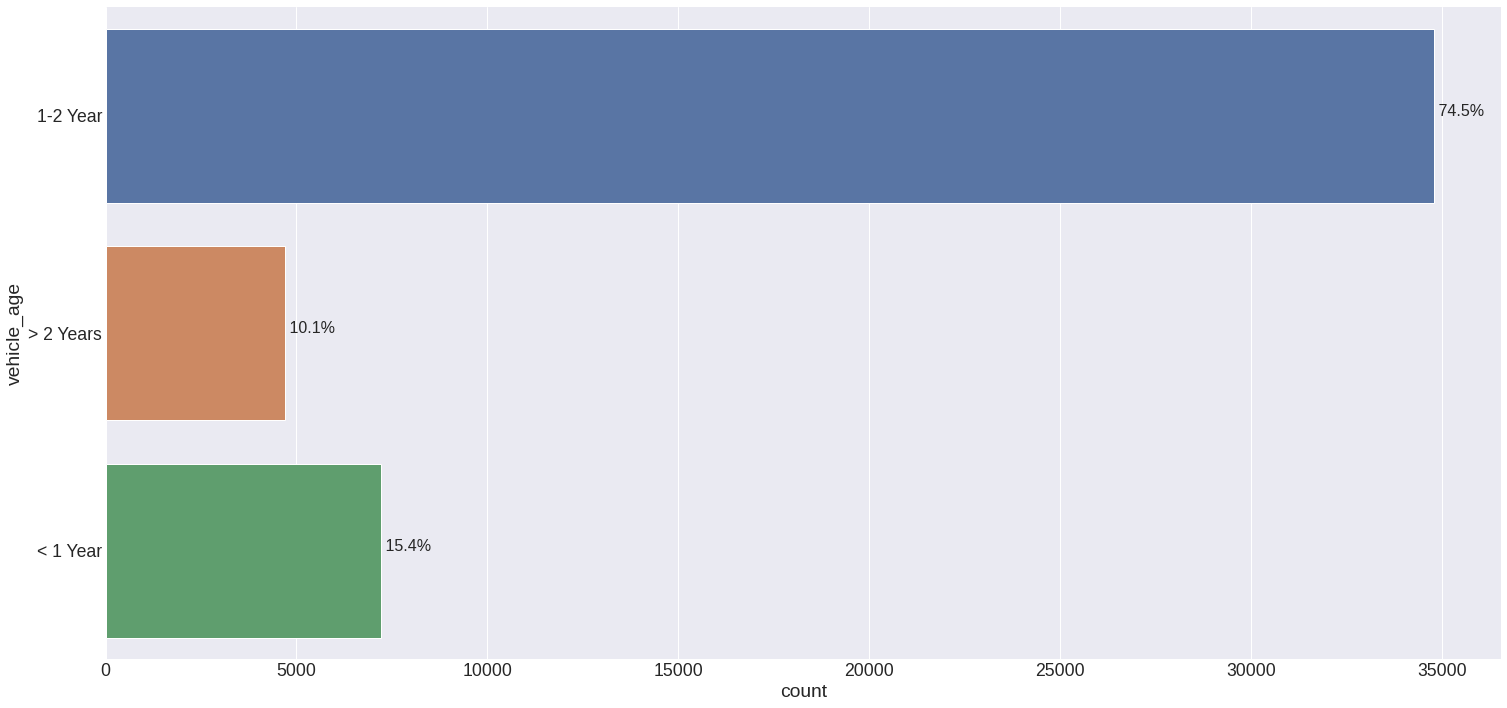

In [121]:
aux1 = df4[df4['response'] == 'yes']
ax = sns.countplot(y='vehicle_age', data=aux1);

total = aux1['vehicle_age'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

#### There is no difference between the number of days.

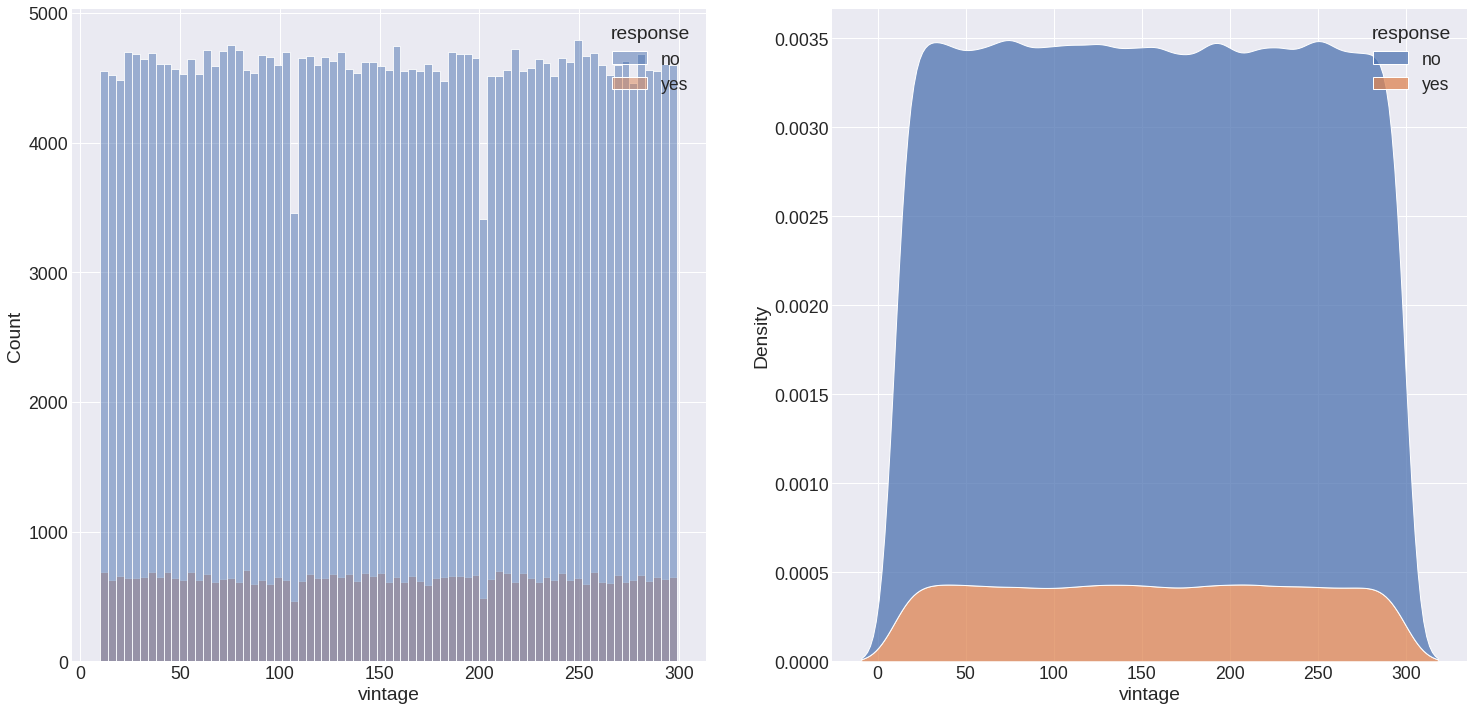

In [122]:
plt.subplot(1, 2, 1)
sns.histplot(x='vintage', data=df4, hue='response')

plt.subplot(1, 2, 2)
sns.kdeplot(x='vintage', data=df4, hue='response', multiple="stack");

### 9.3.2 What percentage of customers are interested in purchasing auto insurance? Will the sales team be able to reach them by making 20,000 calls?

1. The database is based on 46,876 (12.3%) of customers interessed in health insurance and 334,232 (87.7%) of no interested.

1. The model results have shown that the model has the precision of 24.10% (24.14% for a excellent performance or 24.06% for a poor performance). So, using the model it's possible to contact 4,820 (4,828 for a excellent performance or 4,812 for a poor performance) customers interested in health insurance of 20,000 calls. However the recall is about 98.31% (+/- 0.0016).

### 9.3.3 If the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?

Increasing to 40,000 calls the model may help the sales team to contact 9,640 (9,656 for a excellent performance or 9,624 for a poor performance) the customers interested in health insurance.

### 9.3.4 How many calls does the sales team need to make to contact 80% of customers interested in purchasing auto insurance?

The model sorted 98.31% (46,084 customers) of the customer interested in 50% of the database with 381,109 customers. Using the model, it's possible to contact 80% of customers interested in health insurance in 155,064 (155,064 for a excellent performance or 155,064 for a poor performance) calls.

# 10.0 Model Deploy

## 10.1 Loading

In [13]:
df10 =  pd.read_csv('../data/interim/data_step06_temp_cycle1.csv')
X_temp, y_temp = df10.iloc[:, :-1], df10.iloc[:, -1]

## 10.2 Saving

### 10.2.1 One Hot Encoding

In [15]:
ohe_columns = ['previously_insured', 'vehicle_damage']
ohe = ce.OneHotEncoder(cols=ohe_columns, use_cat_names=True)

ohe.fit(X_temp)

OneHotEncoder(cols=['previously_insured', 'vehicle_damage'], use_cat_names=True)

In [16]:
joblib.dump(ohe, '../functions/one_hot_encoder_cycle1.joblib')

['../functions/one_hot_encoder_cycle1.joblib']

### 10.2.2 Target Encoder

In [52]:
te_columns = ['policy_sales_channel']
te = ce.TargetEncoder(cols=te_columns, return_df=False)

te.fit(X_temp[te_columns], y_temp)

TargetEncoder(cols=['policy_sales_channel'], return_df=False)

In [53]:
joblib.dump(te, '../functions/target_encoder_cycle1.joblib')

['../functions/target_encoder_cycle1.joblib']

### 10.2.3 Standard Scaler

In [20]:
ss = StandardScaler()

X_temp['age_bx'] = stats.boxcox(X_temp['age'])[0]
ss.fit(X_temp[['age_bx']])

StandardScaler()

In [21]:
joblib.dump(ss, '../functions/standard_scaler_cycle1.joblib')

['../functions/standard_scaler_cycle1.joblib']

### 10.1.3 MinMax Scaler 

In [22]:
mm = MinMaxScaler()

mm.fit(X_temp[['age']])

MinMaxScaler()

In [23]:
joblib.dump(mm, '../functions/minmax_scaler_cycle1.joblib')

['../functions/minmax_scaler_cycle1.joblib']

### 10.1.4 Model

In [62]:
joblib.dump(final_model, '../models/linear_regression_cycle1.joblib')

['../models/linear_regression_cycle1.joblib']

## 10.2 Cross Sell Class

In [24]:
import joblib
import inflection
import numpy  as np
import pandas as pd
from scipy import stats

class CrossSell:
    
    def __init__(self):
        self.ohe = joblib.load('../functions/one_hot_encoder_cycle1.joblib')
        self.te = joblib.load('../functions/target_encoder_cycle1.joblib')
        self.ss = joblib.load('../functions/standard_scaler_cycle1.joblib')
        self.mm = joblib.load('../functions/minmax_scaler_cycle1.joblib')
        
    def data_preparation(self, df1):

        cols_old = df1.columns.tolist()

        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))

        df1.columns = cols_new

        ## OneHotEncoding
        df1 = df1[['previously_insured', 'vehicle_damage', 'policy_sales_channel', 'age']]
        df1 = self.ohe.transform(df1)
        
        ## Target Encoding
        columns_te = ['policy_sales_channel']
        df1['policy_sales_channel_te'] = self.te.transform(df1[columns_te])
        
        ## BoxCox Transformation
        df1['age_bx'] = stats.boxcox(df1['age'])[0]
        
        ## Standard Scaler
        df1['age_bx_ss'] = self.ss.transform(df1[['age_bx']])
        
        ## MinMax Scaler
        df1['age_mm'] = self.mm.transform(df1[['age']])
        
        cs = ['previously_insured_yes', 'previously_insured_no', 'vehicle_damage_no',
              'vehicle_damage_yes', 'policy_sales_channel_te', 'age_bx_ss', 'age_mm']
        
        return df1[cs]
    
    def get_prediction(self, model, original_data, test_data):
        pred = model.predict(test_data)
        prob = model.predict_proba(test_data)[:, 1]
        
        original_data['prediction'] = pred
        original_data['score'] = prob
        
        original_data.sort_values('score', ascending=False, inplace=True)

        return original_data.to_json(orient="records", date_format="iso")

## 10.3 API Handler

In [147]:
import joblib
import pandas as pd
from crosssell.CrossSell import CrossSell
from flask import Flask, request, Response

## Loading Model
model = joblib.load('../models/linear_regression_cycle1.joblib')

## initialize API
app = Flask(__name__)

@app.route('/crosssell/predict', methods=['POST'])
def crosssell_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instantiate Rossmann class
        pipeline = CrossSell()
        
        # data preparation
        df1 = pipeline.data_preparation(test_raw)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df1)
        
        return df_response

    else:
        return Reponse('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0') 

ModuleNotFoundError: No module named 'crosssell'

## 10.4 API Tester

In [25]:
import json
import requests

In [102]:
## loading a test
df10 = pd.read_csv('../data/raw/test.csv')
df10.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [103]:
# convert Dataframe to json
data = json.dumps(df10.to_dict(orient='records'))

In [104]:
import requests

In [105]:
url = 'http://0.0.0.0:5000/crosssell/predict'
header = {'Content-type': 'application/json'}

r = requests.post(url=url, data=data, headers=header)

In [106]:
r.status_code

200

In [107]:
d = pd.DataFrame(r.json())
d.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,prediction,score
0,407519,Female,80,1,28.0,0,1-2 Year,Yes,44484.0,163.0,104,0,0.440767
1,462040,Male,80,1,11.0,0,1-2 Year,Yes,2630.0,163.0,246,0,0.440767
2,469428,Female,82,1,8.0,0,> 2 Years,Yes,43935.0,157.0,119,0,0.436645
3,391829,Male,79,1,28.0,0,1-2 Year,Yes,48565.0,3.0,222,0,0.436420
4,425777,Male,78,1,3.0,0,1-2 Year,Yes,2630.0,155.0,261,0,0.434927
